In [1]:
import pandas as pd
import numpy as np
import matplotlib.backends.backend_tkagg
import matplotlib.pylab as plt
from astropy.io import fits
from astropy import units as units
import astropy.io.fits as pyfits
from astropy.convolution import Gaussian1DKernel, convolve
from extinction import calzetti00, apply, ccm89
from scipy import optimize
import sys
import time  
from random import randrange, uniform
import emcee
import corner
from multiprocessing import Pool,cpu_count
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
ncpu = cpu_count()
print("{0} CPUs".format(ncpu))
emcee.__version__

8 CPUs


'3.0.2'

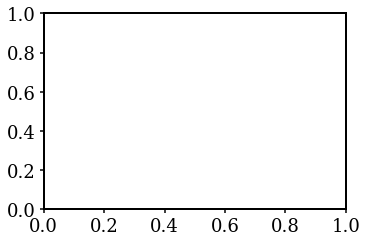

In [3]:
plt.tight_layout()
plt.rc('lines', linewidth=1, markersize=2)
plt.rc('font', size=12, family='serif')
plt.rc('mathtext', fontset='stix')
plt.rc('axes', linewidth=2)
plt.rc('xtick.major', width=1.5, size=4)
plt.rc('ytick.major', width=1.5, size=4)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=18)
plt.subplots_adjust(bottom=0.2, left=0.2)

In [4]:
tik = time.clock()
df_cat=pd.read_csv('/Volumes/My Passport/cosmos_3dhst_v4.1.5_catalogs/cosmos_3dhst.v4.1.5.zbest.rf',delim_whitespace=True,header=None,comment='#',index_col=False)
df_cat.columns=["id", "z_best", "z_type", "z_spec", "DM", "L153", "nfilt153","L154","nfilt154", "L155", "nfilt155", "L161", "nfilt161", \
                "L162", "nfilt162","L163", "nfilt163", "L156", "nfilt156", "L157", "nfilt157", "L158", "nfilt158", "L159", "nfilt159", \
                "L160", "nfilt160", "L135", "nfilt135", "L136", "nfilt136","L137", "nfilt137", "L138", "nfilt138", "L139", "nfilt139", \
                "L270", "nfilt270", "L271", "nfilt271", "L272", "nfilt272", "L273", "nfilt273", "L274", "nfilt274", "L275", "nfilt275"]

# df = pd.read_csv('/Volumes/My Passport/GV_CMD_fn_table_20180904/matching_galaxies_cosmos_20180823_GV.csv', sep=',')
# df = pd.read_csv('/Volumes/My Passport/TPAGB/database/matching_galaxies_cosmos_20200206_PSB.csv', sep=',')
df = pd.read_csv('/Volumes/My Passport/TPAGB/database/matching_galaxies_cosmos_20200301_PSB.csv', sep=',')
df.columns=['detector','ID','region','filename','chip']

df_photometry=pd.read_csv('/Volumes/My Passport/cosmos_3dhst.v4.1.cats/Catalog/cosmos_3dhst.v4.1.cat', delim_whitespace=True,header=None,comment='#',index_col=False)
df_photometry.columns=["id", "x", "y", "ra", "dec", "faper_F160W", "eaper_F160W", "faper_F140W", "eaper_F140W", "f_F160W", "e_F160W", "w_F160W",\
                    "f_U", "e_U", "w_U", "f_B", "e_B", "w_B","f_G", "e_G", "w_G", "f_V", "e_V", "w_V","f_F606W", "e_F606W","w_F606W", \
                    "f_R", "e_R", "w_R", "f_Rp", "e_Rp", "w_Rp","f_I", "e_I", "w_I", "f_Ip", "e_Ip", "w_Ip","f_F814W", "e_F814W","w_F814W", \
                    "f_Z", "e_Z", "w_Z", "f_Zp", "e_Zp", "w_Zp", "f_UVISTA_Y", "e_UVISTA_Y", "w_UVISTA_Y", "f_F125W", "e_F125W", "w_F125W",\
                    "f_J1", "e_J1", "w_J1", "f_J2", "e_J2", "w_J2", "f_J3", "e_J3", "w_J3", "f_J", "e_J", "w_J", "f_UVISTA_J", "e_UVISTA_J", "w_UVISTA_J",\
                    "f_F140W", "e_F140W", "w_F140W","f_H1", "e_H1", "w_H1", "f_H2", "e_H2", "w_H2", "f_H", "e_H", "w_H", "f_UVISTA_H", "e_UVISTA_H", "w_UVISTA_H", \
                    "f_K", "e_K","w_K", "f_Ks", "e_Ks", "w_Ks", "f_UVISTA_Ks", "e_UVISTA_Ks", "w_UVISTA_Ks","f_IRAC1", "e_IRAC1", "w_IRAC1", \
                    "f_IRAC2", "e_IRAC2", "w_IRAC2", "f_IRAC3", "e_IRAC3", "w_IRAC3", "f_IRAC4", "e_IRAC4", "w_IRAC4",\
                     "f_IA427", "e_IA427", "f_IA464", "e_IA464", "f_IA484", "e_IA484", "f_IA505", "e_IA505", "f_IA527", "e_IA527", "f_IA574", "e_IA574",\
                     "f_IA624", "e_IA624", "f_IA679", "e_IA679", "f_IA709", "e_IA709", "f_IA738", "e_IA738", "f_IA767", "e_IA767", "f_IA827", "e_IA827", \
                     "tot_cor", "wmin_ground", "wmin_hst", "wmin_irac", "wmin_wfc3", "z_spec", "star_flag",  "kron_radius", "a_image", "b_image", \
                     "theta_J2000", "class_star", "flux_radius", "fwhm_image", "flags", "IRAC1_contam", "IRAC2_contam", "IRAC3_contam", "IRAC4_contam",\
                      "contam_flag", "f140w_flag", "use_phot", "near_star", "nexp_f125w", "nexp_f140w", "nexp_f160w"]

df_fast = pd.read_csv('/Volumes/My Passport/cosmos_3dhst.v4.1.cats/Fast/cosmos_3dhst.v4.1.fout', delim_whitespace=True, header=None,comment='#',index_col=False)
df_fast.columns = ['id', 'z', 'ltau', 'metal','lage','Av','lmass','lsfr','lssfr','la2t','chi2']
tok = time.clock()
print('Time to read the catalogues:'+str(tok-tik))

# M05
tik2 = time.clock()
norm_wavelength= 5500.0
df_Ma = pd.read_csv('/Volumes/My Passport/M09_ssp_pickles.sed',delim_whitespace=True,header=None,comment='#',index_col=False)# only solar metallicity is contained in this catalogue
df_Ma.columns = ['Age','ZH','l','Flambda']
age = df_Ma.Age
metallicity = df_Ma.ZH
wavelength = df_Ma.l
Flux = df_Ma.Flambda
age_1Gyr_index = np.where(age==1.0)[0]
age_1Gyr = age[age_1Gyr_index]
metallicity_1Gyr = metallicity[age_1Gyr_index]
wavelength_1Gyr = wavelength[age_1Gyr_index]
Flux_1Gyr = Flux[age_1Gyr_index]
F_5500_1Gyr_index=np.where(wavelength_1Gyr==norm_wavelength)[0]
F_5500_1Gyr = Flux_1Gyr[wavelength_1Gyr==norm_wavelength].values # this is the band to be normalized 


# ### M13
df_M13 = pd.read_csv('/Volumes/My Passport/M13_models/sed_M13.ssz002',delim_whitespace=True,header=None,comment='#',index_col=False)
df_M13.columns = ['Age','ZH','l','Flambda']
age_M13 = df_M13.Age
metallicity_M13 = df_M13.ZH
wavelength_M13 = df_M13.l
Flux_M13 = df_M13.Flambda
age_1Gyr_index_M13 = np.where(age_M13==1.0)[0]#[0]
age_1Gyr_M13 = age_M13[age_1Gyr_index_M13]
metallicity_1Gyr_M13 = metallicity_M13[age_1Gyr_index_M13]
wavelength_1Gyr_M13 = wavelength_M13[age_1Gyr_index_M13]
Flux_1Gyr_M13 = Flux_M13[age_1Gyr_index_M13]
F_5500_1Gyr_index_M13=np.where(abs(wavelength_1Gyr_M13-norm_wavelength)<15)[0]
F_5500_1Gyr_M13 = 0.5*(Flux_1Gyr_M13.loc[62271+F_5500_1Gyr_index_M13[0]]+Flux_1Gyr_M13.loc[62271+F_5500_1Gyr_index_M13[1]])


# ### BC03
df_BC = pd.read_csv('/Volumes/My Passport/ssp_900Myr_z02.spec',delim_whitespace=True,header=None,comment='#',index_col=False)
df_BC.columns=['Lambda','Flux']
wavelength_BC = df_BC.Lambda
Flux_BC = df_BC.Flux
F_6000_BC_index=np.where(wavelength_BC==norm_wavelength)[0]
Flux_BC_norm = Flux_BC[F_6000_BC_index]


### Read in the BC03 models High-resolution, with Stelib library, Salpeter IMF, solar metallicity
BC03_fn='/Volumes/My Passport/bc03/models/Stelib_Atlas/Salpeter_IMF/bc2003_hr_stelib_m62_salp_ssp.ised_ASCII'
BC03_file = open(BC03_fn,"r")
BC03_X = []
for line in BC03_file:
    BC03_X.append(line)
BC03_SSP_m62 = np.array(BC03_X)
BC03_age_list = np.array(BC03_SSP_m62[0].split()[1:])
BC03_age_list_num = BC03_age_list.astype(np.float)/1.0e9 # unit is Gyr
BC03_wave_list = np.array(BC03_SSP_m62[6].split()[1:])
BC03_wave_list_num = BC03_wave_list.astype(np.float)
BC03_flux_list = np.array(BC03_SSP_m62[7:-12])
BC03_flux_array = np.zeros((221,7178))
for i in range(221):
    BC03_flux_array[i,:] = BC03_flux_list[i].split()[1:]
    BC03_flux_array[i,:] = BC03_flux_array[i,:]/BC03_flux_array[i,2556]# Normalize the flux

tok2 = time.clock()
print('Time used for the read the models: '+str(tok2-tik2))

columns = ['ID','region','field',
          'M05_age_opt','M05_AV_opt','M13_age_opt','M13_AV_opt','BC_age_opt','BC_AV_opt',\
          'x2_spectra_M05_opt','x2_photo_M05_opt','x2_spectra_M13_opt','x2_photo_M13_opt','x2_spectra_BC_opt','x2_photo_BC_opt',\
          'M05_age_MCMC50','M05_age_std','M05_AV_MCMC50','M05_AV_std','M13_age_MCMC50','M13_age_std','M13_AV_MCMC50','M13_AV_std','BC_age_MCMC50','BC_age_std','BC_AV_MCMC50','BC_AV_std',\
          'x2_spectra_M05_MCMC50','x2_photo_M05_MCMC50','x2_spectra_M13_MCMC50','x2_photo_M13_MCMC50','x2_spectra_BC_MCMC50','x2_photo_BC_MCMC50',\
          'x2_M05_opt','x2_M13_opt','x2_BC_opt','x2_M05_MCMC50','x2_M13_MCMC50','x2_BC_MCMC50',\
          'model','grism_index','grism_index_AV_corr','age_opt','age_opt_std','AV_opt','AV_opt_std']
chi_square_list = pd.DataFrame(index=df.index,columns=columns)#np.zeros([len(df), 31])
chi_square_list_final = pd.DataFrame(index=df.index,columns=columns)

weight1 = 0.25#0.0#1/1.864#/0.5
weight2 = weight1*5e-3#1.0#1/1228.53#/0.5
nsteps=1200
current_dir = '/Volumes/My Passport/TPAGB/'
outcome_dir = 'outcome/'
plot_dir = 'plot/20200302_cosmos/'

Time to read the catalogues:2.6247040000000004
Time used for the read the models: 1.689554000000001


In [5]:
def find_nearest(array,value):
    idx = np.argmin(np.abs(array-value))
    return idx
def read_spectra(row):
    """
    region: default 1 means the first region mentioned in the area, otherwise, the second region/third region
    """
    detector=df.detector[row]
    region = df.region[row]
    chip = df.chip[row]
    ID = df.ID[row]
    redshift_1=df_cat.loc[ID-1].z_best
    mag = -2.5*np.log10(df_cat.loc[ID-1].L161)+25+0.02
    #print mag
    #WFC3 is using the infrared low-resolution grism, and here we are using the z band
    if detector == 'WFC3':
        filename="/Volumes/My Passport/COSMOS_WFC3_V4.1.5/cosmos-"+"{0:02d}".format(region)+"/1D/ASCII/cosmos-"+"{0:02d}".format(region)+"-G141_"+"{0:05d}".format(ID)+".1D.ascii"
        OneD_1 = np.loadtxt(filename,skiprows=1)
    if detector =="ACS":
        filename="/Volumes/My Passport/COSMOS_ACS_V4.1.5/acs-cosmos-"+"{0:02d}".format(region)+"/1D/FITS/"+df.filename[row]
        OneD_1 = fits.getdata(filename, ext=1)
    return ID, OneD_1,redshift_1, mag
def reduced_chi_square(data_wave,data,data_err,model_wave,model):
    n=len(data_wave)
    chi_square = 0
    for i in range(n):
        index = find_nearest(model_wave,data_wave[i]);#print index
        #print (data[i]-model[index])**2/(data_err[i]**2)
        chi_square += (data[i]-model[index])**2/(data_err[i]**2)
        #print chi_square
        # print('chisquare processes',i,chi_square,data[i],model[index],data_err[i])
    reduced_chi_square = chi_square/n
    return reduced_chi_square
def Lick_index_ratio(wave, flux, band=3):
    if band == 3:
        blue_min = 1.06e4  # 1.072e4#
        blue_max = 1.08e4  # 1.08e4#
        red_min = 1.12e4  # 1.097e4#
        red_max = 1.14e4  # 1.106e4#
        band_min = blue_max
        band_max = red_min


    # Blue
    blue_mask = (wave >= blue_min) & (wave <= blue_max)
    blue_wave = wave[blue_mask]
    blue_flux = flux[blue_mask]

    # Red
    red_mask = (wave >= red_min) & (wave <= red_max)
    red_wave = wave[red_mask]
    red_flux = flux[red_mask]

    band_mask = (wave >= band_min) & (wave <= band_max)
    band_wave = wave[band_mask]
    band_flux = flux[band_mask]

    if len(blue_wave) == len(red_wave) and len(blue_wave) != 0:
        ratio = np.mean(blue_flux) / np.mean(red_flux)
    elif red_wave == []:
        ratio = np.mean(blue_flux) / np.mean(red_flux)
    elif len(blue_wave) != 0 and len(red_wave) != 0:
        ratio = np.mean(blue_flux) / np.mean(red_flux)

    # ratio_err = np.sqrt(np.sum(1/red_flux**2*blue_flux_err**2)+np.sum((blue_flux/red_flux**2*red_flux_err)**2))

    return ratio  # , ratio_err
def binning_spec_keep_shape(wave,flux,bin_size):
    wave_binned = wave
    flux_binned = np.zeros(len(wave))
    for i in range((int(len(wave)/bin_size))):
        flux_binned[bin_size*i:bin_size*(i+1)] = np.mean(flux[bin_size*i:bin_size*(i+1)])
    return wave_binned, flux_binned#, flux_err_binned
def derive_1D_spectra_Av_corrected(OneD_1, redshift_1, rownumber, wave_list, band_list, photometric_flux, photometric_flux_err, A_v):
    """
    OneD_1 is the oneD spectra
    redshift_1 is the redshift of the spectra
    rownumber is the row number in order to store the spectra
    """
    region = df.region[rownumber]
    ID = df.ID[rownumber]
    n = len(OneD_1)
    age = 10**(df_fast.loc[ID-1].lage)/1e9 ## in Gyr
    metal = df_fast.loc[ID-1].metal
    sfr = 10**(df_fast.loc[ID-1].lsfr)
    intrinsic_Av = df_fast.loc[ID-1].Av
    
    
    # Normalize and smooth the models, smoothing BC to delta_lambda =14, smoothing Ma05 to be delta_lambda = 10
    norm_factor_BC = int((OneD_1[int(n/2+1)][0]-OneD_1[int(n/2)][0])/(1+redshift_1)/1)
    norm_limit_BC = int(5930/norm_factor_BC)*norm_factor_BC+400
    smooth_wavelength_BC_1 = wavelength_BC[400:norm_limit_BC].values.reshape(-1,norm_factor_BC).mean(axis=1)
    smooth_wavelength_BC = np.hstack([smooth_wavelength_BC_1,wavelength_BC[norm_limit_BC:]])

    smooth_Flux_BC_1 = Flux_BC[400:norm_limit_BC].values.reshape(-1,norm_factor_BC).mean(axis=1)
    smooth_Flux_BC = np.hstack([smooth_Flux_BC_1,Flux_BC[norm_limit_BC:]])/Flux_BC_norm.values[0]
    
    norm_factor_Ma = int((OneD_1[int(n/2+1)][0]-OneD_1[int(n/2)][0])/(1+redshift_1)/5)
    norm_limit_Ma = int(4770/norm_factor_Ma)*norm_factor_Ma
    smooth_wavelength_Ma = wavelength_1Gyr[:norm_limit_Ma].values.reshape(-1,norm_factor_Ma).mean(axis=1)
    smooth_Flux_Ma_1Gyr = Flux_1Gyr[:norm_limit_Ma].values.reshape(-1,norm_factor_Ma).mean(axis=1)/F_5500_1Gyr
    
    if redshift_1<=0.1:
        i = 33
        temp_norm_wave = wave_list[i]/(1+redshift_1)
        index_wave_norm = find_nearest(smooth_wavelength_BC,temp_norm_wave)
        norm_band = photometric_flux[i] 
        #plt.text(5000,0.55,'normalized at IA574: rest frame '+"{0:.2f}".format(temp_norm_wave),fontsize=16)
        #plt.axvline(temp_norm_wave,linewidth=2,color='b')
    elif redshift_1<=0.19:
        i = 25
        temp_norm_wave = wave_list[i]/(1+redshift_1)
        index_wave_norm = find_nearest(smooth_wavelength_BC,temp_norm_wave)
        norm_band = photometric_flux[i] 
        #plt.text(5000,0.55,'normalized at Rp: rest frame '+"{0:.2f}".format(temp_norm_wave),fontsize=16)
        #plt.axvline(temp_norm_wave,linewidth=2,color='b')
    elif redshift_1<=0.28:
        i = 35
        temp_norm_wave = wave_list[i]/(1+redshift_1)
        index_wave_norm = find_nearest(smooth_wavelength_BC,temp_norm_wave)
        norm_band = photometric_flux[i] #i
        #plt.text(5000,0.55,'normalized at IA679: rest frame '+"{0:.2f}".format(temp_norm_wave),fontsize=16)
        #plt.axvline(temp_norm_wave,linewidth=2,color='b') 
    elif redshift_1<=0.39:
        i = 37
        temp_norm_wave = wave_list[i]/(1+redshift_1)
        index_wave_norm = find_nearest(smooth_wavelength_BC,temp_norm_wave)
        norm_band = photometric_flux[i] 
        #plt.text(5000,0.55,'normalized at IA738: rest frame '+"{0:.2f}".format(temp_norm_wave),fontsize=16)
        #plt.axvline(temp_norm_wave,linewidth=2,color='b')
    elif redshift_1<=0.45:
        i = 38
        temp_norm_wave = wave_list[i]/(1+redshift_1)
        index_wave_norm = find_nearest(smooth_wavelength_BC,temp_norm_wave)
        norm_band = photometric_flux[i] 
        #plt.text(5000,0.55,'normalized at IA767: rest frame '+"{0:.2f}".format(temp_norm_wave),fontsize=16)
        #plt.axvline(temp_norm_wave,linewidth=2,color='b')
    elif redshift_1<=0.55:
        i = 39
        temp_norm_wave = wave_list[i]/(1+redshift_1)
        index_wave_norm = find_nearest(smooth_wavelength_BC,temp_norm_wave)
        norm_band = photometric_flux[i] 
        #plt.text(5000,0.55,'normalized at IA827: rest frame '+"{0:.2f}".format(temp_norm_wave),fontsize=16)
        #plt.axvline(temp_norm_wave,linewidth=2,color='b')
    elif redshift_1<=0.62:
        i = 4
        temp_norm_wave = wave_list[i]/(1+redshift_1)
        index_wave_norm = find_nearest(smooth_wavelength_BC,temp_norm_wave)
        norm_band = photometric_flux[i] 
        #plt.text(5000,0.55,'normalized at z: rest frame '+"{0:.2f}".format(temp_norm_wave),fontsize=16)
        #plt.axvline(temp_norm_wave,linewidth=2,color='b')
    else:
        i = 27
        temp_norm_wave = wave_list[i]/(1+redshift_1)
        index_wave_norm = find_nearest(smooth_wavelength_BC,temp_norm_wave)
        norm_band = photometric_flux[i] 
        #plt.text(5000,0.55,'normalized at Zp: rest frame '+"{0:.2f}".format(temp_norm_wave),fontsize=16)
        #plt.axvline(temp_norm_wave,linewidth=2,color='b')
    
    x = np.zeros(n)
    y = np.zeros(n)
    y_err = np.zeros(n)
    contam = np.zeros(n)

    for i in range(0,n):
        x[i] = OneD_1[i][0]

    #spectra_extinction = ccm89(x, A_v, 3.1)
    spectra_extinction = calzetti00(x, A_v, 4.05)
    for i in range(n):
        #spectra_extinction = extinction.extinction(x[i]*units.angstrom, a_v=A_v, r_v=3.1, model='d03')
        spectra_flux_correction = 10**(0.4*spectra_extinction[i])# from obs to obtain the true value: the absolute value
        x[i] = x[i]/(1+redshift_1)
        y[i] = (OneD_1[i][1]-OneD_1[i][3])/OneD_1[i][6]*spectra_flux_correction#/Flux_0 # (flux-contamination)/sensitivity
        y_err[i] = OneD_1[i][2]/OneD_1[i][6]*spectra_flux_correction#/Flux_0
        contam[i] = OneD_1[i][3]

    contam_min, contam_max = np.percentile(contam,[16,84])
    index_start = np.where(contam>=contam_min)[0][0]
    index_end = np.where(contam<=contam_max)[0][-1]
    mask_non_neg = np.where(y>0)
    x = x[index_start:index_end+1]#[int(n*2/10):int(n*8/10)]
    y = y[index_start:index_end+1]*1e-17/norm_band#[int(n*2/10):int(n*8/10)]*1e-17/norm_band
    y_err = y_err[index_start:index_end+1]*1e-17/norm_band#[int(n*2/10):int(n*8/10)]*1e-17/norm_band
    
    mask_non_neg = np.where(y>0)
    x = x[mask_non_neg]
    y = y[mask_non_neg]
    y_err = y_err[mask_non_neg]

    mask_non_neg_2 = np.where(y_err>0)
    x = x[mask_non_neg_2]
    y = y[mask_non_neg_2]
    y_err = y_err[mask_non_neg_2]

    mask_large_err = np.where(y_err/y<1)
    x = x[mask_large_err]
    y = y[mask_large_err]
    y_err = y_err[mask_large_err]

    mask_non_neg_photo = np.where(photometric_flux>0)
    wave_list = wave_list[mask_non_neg_photo]
    band_list = band_list[mask_non_neg_photo]
    photometric_flux = photometric_flux[mask_non_neg_photo]
    photometric_flux_err = photometric_flux_err[mask_non_neg_photo]

    return x, y, y_err, wave_list/(1+redshift_1), band_list/(1+redshift_1), photometric_flux/norm_band, photometric_flux_err/norm_band    
def model_identification(chi2_array,rtol=0.1):
    index = find_nearest(chi2_array,1)    
    model = np.mod(index,3)+1
    chi2_array_comp = abs(chi2_array-1)
    chi2_array_comp_idx = np.argsort(chi2_array_comp)[:2]
    if np.mod(chi2_array_comp_idx[0],3)==np.mod(chi2_array_comp_idx[1],3):
        chi2_array_comp_idx = np.argsort(chi2_array_comp)[1:3]
    chi2_min2_array = chi2_array[chi2_array_comp_idx]
    if np.isclose(chi2_min2_array[0],chi2_min2_array[1],rtol=rtol):
        model = 0
    return model
def model_from_chi2(df_opt):
    for i in range(len(df_opt)):
        chi2_array=df_opt.loc[i,['x2_M05_opt','x2_M13_opt','x2_BC_opt',\
                                 'x2_M05_MCMC50','x2_M13_MCMC50','x2_BC_MCMC50']].values
        chi2_spec_array=df_opt.loc[i,['x2_spectra_M05_opt','x2_spectra_M13_opt','x2_spectra_BC_opt',\
                                      'x2_spectra_M05_MCMC50','x2_spectra_M13_MCMC50','x2_spectra_BC_MCMC50']].values
        chi2_phot_array=df_opt.loc[i,['x2_photo_M05_opt','x2_photo_M13_opt','x2_photo_BC_opt',\
                                      'x2_photo_M05_MCMC50','x2_photo_M13_MCMC50','x2_photo_BC_MCMC50']].values
        age_array=df_opt.loc[i,['M05_age_opt','M13_age_opt','BC_age_opt',\
                                'M05_age_MCMC50','M13_age_MCMC50','BC_age_MCMC50']].values
        age_std_array=df_opt.loc[i,['M05_age_std','M13_age_std','BC_age_std',\
                                    'M05_age_std','M13_age_std','BC_age_std']].values
        AV_array=df_opt.loc[i,['M05_AV_opt','M13_AV_opt','BC_AV_opt',\
                               'M05_AV_MCMC50','M13_AV_MCMC50','BC_AV_MCMC50']].values
        AV_std_array=df_opt.loc[i,['M05_AV_std','M13_AV_std','BC_AV_std',\
                                   'M05_AV_std','M13_AV_std','BC_AV_std']].values        
        index = find_nearest(chi2_array,0)    
        df_opt.loc[i,'model'] = np.mod(index,3)+1
        df_opt.loc[i,'model_new']=model_identification(chi2_array)
        df_opt.loc[i,'best_chi2']=chi2_array[index]
        df_opt.loc[i,'best_chi2_spec']=chi2_spec_array[index]
        df_opt.loc[i,'best_chi2_phot']=chi2_phot_array[index]
        df_opt.loc[i,'age_opt']=age_array[index]
        df_opt.loc[i,'age_opt_std']=age_std_array[index]
        df_opt.loc[i,'AV_opt']=AV_array[index]
        df_opt.loc[i,'AV_opt_std']=AV_std_array[index]
    return df_opt
    for i in range(len(df_opt)):
        chi2_array=df_opt.loc[i,['x2_M05_opt','x2_M13_opt','x2_BC_opt','x2_M05_MCMC50','x2_M13_MCMC50','x2_BC_MCMC50']].values
        chi2_spec_array=df_opt.loc[i,['x2_spectra_M05_opt','x2_spectra_M13_opt','x2_spectra_BC_opt','x2_spectra_M05_MCMC50','x2_spectra_M13_MCMC50','x2_spectra_BC_MCMC50']].values
        chi2_phot_array=df_opt.loc[i,['x2_photo_M05_opt','x2_photo_M13_opt','x2_photo_BC_opt','x2_photo_M05_MCMC50','x2_photo_M13_MCMC50','x2_photo_BC_MCMC50']].values
        age_array=df_opt.loc[i,['M05_age_opt','M13_age_opt','BC_age_opt','M05_age_MCMC50','M13_age_MCMC50','BC_age_MCMC50']].values
        age_std_array=df_opt.loc[i,['M05_age_std','M13_age_std','BC_age_std','M05_age_std','M13_age_std','BC_age_std']].values
        AV_array=df_opt.loc[i,['M05_AV_opt','M13_AV_opt','BC_AV_opt','M05_AV_MCMC50','M13_AV_MCMC50','BC_AV_MCMC50']].values
        AV_std_array=df_opt.loc[i,['M05_AV_std','M13_AV_std','BC_AV_std','M05_AV_std','M13_AV_std','BC_AV_std']].values
        index = find_nearest(chi2_array,1)
        df_opt.loc[i,'model']=np.mod(index,3)+1
        df_opt.loc[i,'best_chi2']=chi2_array[index]
        df_opt.loc[i,'best_chi2_spec']=chi2_spec_array[index]
        df_opt.loc[i,'best_chi2_phot']=chi2_phot_array[index]
        df_opt.loc[i,'age_opt']=age_array[index]
        df_opt.loc[i,'age_opt_std']=age_std_array[index]
        df_opt.loc[i,'AV_opt']=AV_array[index]
        df_opt.loc[i,'AV_opt_std']=AV_std_array[index]

def binning_spec_keep_shape_x(wave,flux,flux_err,bin_size):
    wave_binned = wave
    flux_binned = np.zeros(len(wave))
    flux_err_binned = np.zeros(len(wave))
    for i in range((int(len(wave)/bin_size))+1):
        flux_binned[bin_size*i:bin_size*(i+1)] = np.mean(flux[bin_size*i:bin_size*(i+1)])
        flux_err_binned[bin_size*i:bin_size*(i+1)] = np.mean(flux_err[bin_size*i:bin_size*(i+1)])
    return wave_binned, flux_binned, flux_err_binned
def minimize_age_AV_vector_weighted(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]

    n=len(x)
    age_index = find_nearest(df_Ma.Age.unique(), galaxy_age)
    age_prior = df_Ma.Age.unique()[age_index]
    AV_string = str(intrinsic_Av)
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')

    if age_prior < 1:
        fn1 = '/Volumes/My Passport/SSP_models/M05_age_'+'0_'+split_galaxy_age_string[1]+'_Av_00_z002.csv'
        model1 = np.genfromtxt(fn1)
    elif age_prior == 1.5:
        if galaxy_age >=1.25 and galaxy_age <1.5:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            model1 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 1.5 and galaxy_age <= 1.75:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
            model1 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
    elif len(split_galaxy_age_string[1])==1:
        if galaxy_age >= 1.0 and galaxy_age < 1.25:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            model1 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >=1.75 and galaxy_age < 2.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
            model1 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
        elif galaxy_age >= 2.0 and galaxy_age < 3.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_3_Av_00_z002.csv'
            model1 = (3.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-2.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 3.0 and galaxy_age < 4.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_3_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_4_Av_00_z002.csv'
            model1 = (4.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-3.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 4.0 and galaxy_age < 5.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_4_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_5_Av_00_z002.csv'
            model1 = (5.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-4.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 5.0 and galaxy_age < 6.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_6_Av_00_z002.csv'
            model1 = (6.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-5.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 6.0 and galaxy_age < 7.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_6_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_7_Av_00_z002.csv'
            model1 = (7.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-6.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 7.0 and galaxy_age < 8.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_7_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_8_Av_00_z002.csv'
            model1 = (8.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-7.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 8.0 and galaxy_age < 9.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_8_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_9_Av_00_z002.csv'
            model1 = (9.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-8.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 9.0 and galaxy_age < 10.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_9_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_10_Av_00_z002.csv'
            model1 = (10.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-9.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 10.0 and galaxy_age < 11.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_10_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_11_Av_00_z002.csv'
            model1 = (11.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-10.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 11.0 and galaxy_age < 12.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_11_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_12_Av_00_z002.csv'
            model1 = (12.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-11.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 12.0 and galaxy_age < 13.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_12_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_13_Av_00_z002.csv'
            model1 = (13.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-12.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 13.0 and galaxy_age < 14.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_13_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_14_Av_00_z002.csv'
            model1 = (14.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-13.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 14.0 and galaxy_age < 15.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_14_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_15_Av_00_z002.csv'
            model1 = (15.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-14.0)*np.genfromtxt(fn2)
        else:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_'+split_galaxy_age_string[0]+'_Av_00_z002.csv'
            model1 = np.genfromtxt(fn1)

    spectra_extinction = calzetti00(model1[0,:], intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    M05_flux_center = model1[1,:]*spectra_flux_correction
    F_M05_index=167
    Flux_M05_norm_new = M05_flux_center[F_M05_index]
    smooth_Flux_Ma_1Gyr_new = M05_flux_center/Flux_M05_norm_new
    # print('Age',galaxy_age, age_prior)

    binning_index = find_nearest(model1[0,:],np.median(x))
    if (x[int(n/2)]-x[int(n/2)-1]) > (model1[0,binning_index]-model1[0,binning_index-1]):
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(model1[0,binning_index]-model1[0,binning_index-1]))
        model_wave_binned,model_flux_binned = binning_spec_keep_shape(model1[0,:], smooth_Flux_Ma_1Gyr_new,binning_size)
        # print('model flux before binning:',smooth_Flux_Ma_1Gyr_new)
        # print('binned model flux', model_flux_binned)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        # print('binning model, model 1', n, (model1[0,binning_index]-model1[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)
    else:
        binning_size = int((model1[0,binning_index]-model1[0,binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned=binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, model1[0,:], smooth_Flux_Ma_1Gyr_new) 
        # print('binning data, model 1', n, (model1[0,binning_index]-model1[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)
    x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, model1[0,:], smooth_Flux_Ma_1Gyr_new)
    
    return 0.5*weight1*x2+0.5*weight2*x2_photo
def lg_minimize_age_AV_vector_weighted(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(df_Ma.Age.unique(), galaxy_age)
    age_prior = df_Ma.Age.unique()[age_index]
    AV_string = str(intrinsic_Av)
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')

    if age_prior < 1:
        fn1 = '/Volumes/My Passport/SSP_models/M05_age_'+'0_'+split_galaxy_age_string[1]+'_Av_00_z002.csv'
        model1 = np.genfromtxt(fn1)
    elif age_prior == 1.5:
        if galaxy_age >=1.25 and galaxy_age <1.5:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            model1 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 1.5 and galaxy_age <= 1.75:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
            model1 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
    elif len(split_galaxy_age_string[1])==1:
        if galaxy_age >= 1.0 and galaxy_age < 1.25:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            model1 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >=1.75 and galaxy_age < 2.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
            model1 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
        elif galaxy_age >= 2.0 and galaxy_age < 3.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_3_Av_00_z002.csv'
            model1 = (3.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-2.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 3.0 and galaxy_age < 4.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_3_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_4_Av_00_z002.csv'
            model1 = (4.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-3.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 4.0 and galaxy_age < 5.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_4_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_5_Av_00_z002.csv'
            model1 = (5.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-4.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 5.0 and galaxy_age < 6.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_6_Av_00_z002.csv'
            model1 = (6.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-5.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 6.0 and galaxy_age < 7.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_6_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_7_Av_00_z002.csv'
            model1 = (7.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-6.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 7.0 and galaxy_age < 8.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_7_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_8_Av_00_z002.csv'
            model1 = (8.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-7.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 8.0 and galaxy_age < 9.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_8_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_9_Av_00_z002.csv'
            model1 = (9.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-8.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 9.0 and galaxy_age < 10.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_9_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_10_Av_00_z002.csv'
            model1 = (10.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-9.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 10.0 and galaxy_age < 11.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_10_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_11_Av_00_z002.csv'
            model1 = (11.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-10.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 11.0 and galaxy_age < 12.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_11_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_12_Av_00_z002.csv'
            model1 = (12.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-11.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 12.0 and galaxy_age < 13.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_12_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_13_Av_00_z002.csv'
            model1 = (13.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-12.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 13.0 and galaxy_age < 14.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_13_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_14_Av_00_z002.csv'
            model1 = (14.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-13.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 14.0 and galaxy_age < 15.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_14_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_15_Av_00_z002.csv'
            model1 = (15.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-14.0)*np.genfromtxt(fn2)
        else:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_'+split_galaxy_age_string[0]+'_Av_00_z002.csv'
            model1 = np.genfromtxt(fn1)

    spectra_extinction = calzetti00(model1[0,:], intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    M05_flux_center = model1[1,:]*spectra_flux_correction
    F_M05_index=167
    Flux_M05_norm_new = M05_flux_center[F_M05_index]
    smooth_Flux_Ma_1Gyr_new = M05_flux_center/Flux_M05_norm_new

    binning_index = find_nearest(model1[0,:],np.median(x))
    if (x[int(n/2)]-x[int(n/2)-1]) > (model1[0,binning_index]-model1[0,binning_index-1]):
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(model1[0,binning_index]-model1[0,binning_index-1]))
        model_wave_binned,model_flux_binned = binning_spec_keep_shape(model1[0,:], smooth_Flux_Ma_1Gyr_new,binning_size)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        # print('binning model, model 1', n, (model1[0,binning_index]-model1[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)
    else:
        binning_size = int((model1[0,binning_index]-model1[0,binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned=binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, model1[0,:], smooth_Flux_Ma_1Gyr_new) 
        # print('binning data, model 1', n, (model1[0,binning_index]-model1[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)
    x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, model1[0,:], smooth_Flux_Ma_1Gyr_new)
    
    if 0.01<galaxy_age<13.0 and 0.0<intrinsic_Av<4.0 and not np.isinf(x2+1e-3*x2_photo):
        return np.log(np.exp(-0.5*(0.5*weight1*x2+0.5*weight2*x2_photo)))
    else:
        return -np.inf
def minimize_age_AV_vector_weighted_return_flux(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(df_Ma.Age.unique(), galaxy_age)
    age_prior = df_Ma.Age.unique()[age_index]
    #print('galaxy age', galaxy_age, 'age prior:', age_prior)
    AV_string = str(intrinsic_Av)
    #print('intrinsic Av:', intrinsic_Av)
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')

    if age_prior < 1:
        fn1 = '/Volumes/My Passport/SSP_models/M05_age_'+'0_'+split_galaxy_age_string[1]+'_Av_00_z002.csv'
        model1 = np.genfromtxt(fn1)
    elif age_prior == 1.5:
        if galaxy_age >=1.25 and galaxy_age <1.5:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 1.5 and galaxy_age <= 1.75:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
    elif len(split_galaxy_age_string[1])==1:
        if galaxy_age >= 1.0 and galaxy_age <= 1.25:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >=1.75 and galaxy_age < 2.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
        elif galaxy_age >= 2.0 and galaxy_age < 3.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_3_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (3.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-2.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 3.0 and galaxy_age < 4.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_3_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_4_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (4.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-3.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 4.0 and galaxy_age < 5.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_4_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_5_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (5.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-4.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 5.0 and galaxy_age < 6.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_6_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (6.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-5.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 6.0 and galaxy_age < 7.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_6_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_7_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (7.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-6.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 7.0 and galaxy_age < 8.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_7_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_8_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (8.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-7.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 8.0 and galaxy_age < 9.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_8_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_9_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (9.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-8.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 9.0 and galaxy_age < 10.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_9_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_10_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (10.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-9.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 10.0 and galaxy_age < 11.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_10_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_11_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (11.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-10.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 11.0 and galaxy_age < 12.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_11_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_12_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (12.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-11.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 12.0 and galaxy_age < 13.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_12_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_13_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (13.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-12.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 13.0 and galaxy_age < 14.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_13_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_14_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (14.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-13.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 14.0 and galaxy_age < 15.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_14_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_15_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (15.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-14.0)*np.genfromtxt(fn2)
        else:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_'+split_galaxy_age_string[0]+'_Av_00_z002.csv'
            model1 = np.genfromtxt(fn1)

    spectra_extinction = calzetti00(model1[0,:], intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    M05_flux_center = model1[1,:]*spectra_flux_correction
    F_M05_index=167
    Flux_M05_norm_new = M05_flux_center[F_M05_index]
    smooth_Flux_Ma_1Gyr_new = M05_flux_center/Flux_M05_norm_new

    binning_index = find_nearest(model1[0,:],np.median(x))
    if (x[int(n/2)]-x[int(n/2)-1]) > (model1[0,binning_index]-model1[0,binning_index-1]):
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(model1[0,binning_index]-model1[0,binning_index-1]))
        model_wave_binned,model_flux_binned = binning_spec_keep_shape(model1[0,:], smooth_Flux_Ma_1Gyr_new,binning_size)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        # print('binning model, model 1', n, (model1[0,binning_index]-model1[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)
    else:
        binning_size = int((model1[0,binning_index]-model1[0,binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned=binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, model1[0,:], smooth_Flux_Ma_1Gyr_new) 
        # print('binning data, model 1', n, (model1[0,binning_index]-model1[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)
    x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, model1[0,:], smooth_Flux_Ma_1Gyr_new)
    
    return 0.5*weight1*x2+0.5*weight2*x2_photo, model1[0,:], smooth_Flux_Ma_1Gyr_new
def minimize_age_AV_vector_weighted_return_chi2_sep(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(df_Ma.Age.unique(), galaxy_age)
    age_prior = df_Ma.Age.unique()[age_index]
    #print('galaxy age', galaxy_age, 'age prior:', age_prior)
    AV_string = str(intrinsic_Av)
    #print('intrinsic Av:', intrinsic_Av)
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')

    if age_prior < 1:
        fn1 = '/Volumes/My Passport/SSP_models/M05_age_'+'0_'+split_galaxy_age_string[1]+'_Av_00_z002.csv'
        model1 = np.genfromtxt(fn1)
    elif age_prior == 1.5:
        if galaxy_age >=1.25 and galaxy_age <1.5:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 1.5 and galaxy_age <= 1.75:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
    elif len(split_galaxy_age_string[1])==1:
        if galaxy_age >= 1.0 and galaxy_age < 1.25:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >=1.75 and galaxy_age < 2.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
        elif galaxy_age >= 2.0 and galaxy_age < 3.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_3_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (3.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-2.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 3.0 and galaxy_age < 4.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_3_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_4_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (4.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-3.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 4.0 and galaxy_age < 5.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_4_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_5_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (5.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-4.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 5.0 and galaxy_age < 6.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_6_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (6.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-5.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 6.0 and galaxy_age < 7.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_6_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_7_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (7.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-6.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 7.0 and galaxy_age < 8.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_7_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_8_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (8.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-7.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 8.0 and galaxy_age < 9.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_8_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_9_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (9.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-8.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 9.0 and galaxy_age < 10.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_9_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_10_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (10.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-9.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 10.0 and galaxy_age < 11.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_10_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_11_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (11.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-10.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 11.0 and galaxy_age < 12.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_11_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_12_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (12.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-11.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 12.0 and galaxy_age < 13.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_12_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_13_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (13.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-12.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 13.0 and galaxy_age < 14.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_13_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_14_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (14.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-13.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 14.0 and galaxy_age < 15.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_14_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_15_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (15.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-14.0)*np.genfromtxt(fn2)
        else:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_'+split_galaxy_age_string[0]+'_Av_00_z002.csv'
            model1 = np.genfromtxt(fn1)

    spectra_extinction = calzetti00(model1[0,:], intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    M05_flux_center = model1[1,:]*spectra_flux_correction
    F_M05_index=167
    Flux_M05_norm_new = M05_flux_center[F_M05_index]
    smooth_Flux_Ma_1Gyr_new = M05_flux_center/Flux_M05_norm_new
    
    binning_index = find_nearest(model1[0,:],np.median(x))
    if (x[int(n/2)]-x[int(n/2)-1]) > (model1[0,binning_index]-model1[0,binning_index-1]):
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(model1[0,binning_index]-model1[0,binning_index-1]))
        model_wave_binned,model_flux_binned = binning_spec_keep_shape(model1[0,:], smooth_Flux_Ma_1Gyr_new,binning_size)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        # print('binning model, model 1', n, (model1[0,binning_index]-model1[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)
    else:
        binning_size = int((model1[0,binning_index]-model1[0,binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned=binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, model1[0,:], smooth_Flux_Ma_1Gyr_new) 
        # print('binning data, model 1', n, (model1[0,binning_index]-model1[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)
    x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, model1[0,:], smooth_Flux_Ma_1Gyr_new)
    
    return x2,x2_photo

def minimize_age_AV_vector_weighted_M13(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(df_M13.Age.unique(), galaxy_age)
    age_prior = df_M13.Age.unique()[age_index]
    age_prior = float(age_prior)
    AV_string = str(intrinsic_Av)
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')

    if age_prior < 1e-4:
        fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+'0_0001_Av_00_z002.csv'
        model2 = np.genfromtxt(fn1)
    elif age_prior < 1 and age_prior>=1e-4:
        fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+'0_'+split_galaxy_age_string[1]+'_Av_00_z002.csv'
        model2 = np.genfromtxt(fn1)
    elif age_prior == 1.5:
        if galaxy_age >=1.25 and galaxy_age <1.5:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            model2 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 1.5 and galaxy_age <= 1.75:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
            model2 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
    elif len(split_galaxy_age_string[1])==1:
        if galaxy_age >= 1.0 and galaxy_age < 1.25:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            model2 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >=1.75 and galaxy_age < 2.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
            model2 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
        elif galaxy_age >= 2.0 and galaxy_age < 3.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_3_Av_00_z002.csv'
            model2 = (3.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-2.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 3.0 and galaxy_age < 4.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_3_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_4_Av_00_z002.csv'
            model2 = (4.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-3.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 4.0 and galaxy_age < 5.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_4_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_5_Av_00_z002.csv'
            model2 = (5.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-4.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 5.0 and galaxy_age < 6.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_6_Av_00_z002.csv'
            model2 = (6.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-5.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 6.0 and galaxy_age < 7.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_6_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_7_Av_00_z002.csv'
            model2 = (7.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-6.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 7.0 and galaxy_age < 8.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_7_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_8_Av_00_z002.csv'
            model2 = (8.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-7.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 8.0 and galaxy_age < 9.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_8_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_9_Av_00_z002.csv'
            model2 = (9.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-8.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 9.0 and galaxy_age < 10.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_9_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_10_Av_00_z002.csv'
            model2 = (10.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-9.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 10.0 and galaxy_age < 11.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_10_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_11_Av_00_z002.csv'
            model2 = (11.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-10.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 11.0 and galaxy_age < 12.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_11_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_12_Av_00_z002.csv'
            model2 = (12.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-11.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 12.0 and galaxy_age < 13.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_12_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_13_Av_00_z002.csv'
            model2 = (13.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-12.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 13.0 and galaxy_age < 14.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_13_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_14_Av_00_z002.csv'
            model2 = (14.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-13.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 14.0 and galaxy_age < 15.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_14_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_15_Av_00_z002.csv'
            model2 = (15.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-14.0)*np.genfromtxt(fn2)
        else:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+split_galaxy_age_string[0]+'_Av_00_z002.csv'
            model2 = np.genfromtxt(fn1)

    spectra_extinction = calzetti00(model2[0,:], intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    M13_flux_center = model2[1,:]*spectra_flux_correction
    F_M13_index = 126##np.where(abs(model2[0,:]-norm_wavelength)<10.5)[0][0]
    Flux_M13_norm_new = M13_flux_center[F_M13_index]
    smooth_Flux_M13_1Gyr_new = M13_flux_center/Flux_M13_norm_new
    
    binning_index = find_nearest(model2[0,:],np.median(x))
    if (x[int(n/2)]-x[int(n/2)-1]) > (model2[0,binning_index]-model2[0,binning_index-1]):
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(model2[0,binning_index]-model2[0,binning_index-1]))
        model_wave_binned,model_flux_binned = binning_spec_keep_shape(model2[0,:], smooth_Flux_M13_1Gyr_new)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        # print('binning model, model 2', n, (model2[0,binning_index]-model2[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]),binning_size)    
    else:
        binning_size = int((model2[0,binning_index]-model2[0,binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned = binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, model2[0,:], smooth_Flux_M13_1Gyr_new) 
        # print('binning data, model 2', n, (model2[0,binning_index]-model2[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]),binning_size)    
    x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, model2[0,:], smooth_Flux_M13_1Gyr_new)
    
    return 0.5*weight1*x2+0.5*weight2*x2_photo
def lg_minimize_age_AV_vector_weighted_M13(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(df_M13.Age.unique(), galaxy_age)
    age_prior = df_M13.Age.unique()[age_index]
    age_prior = float(age_prior)
    AV_string = str(intrinsic_Av)
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')

    if age_prior < 1e-4:
        fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+'0_0001_Av_00_z002.csv'
        model2 = np.genfromtxt(fn1)
    elif age_prior < 1 and age_prior>=1e-4:
        fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+'0_'+split_galaxy_age_string[1]+'_Av_00_z002.csv'
        model2 = np.genfromtxt(fn1)
    elif age_prior == 1.5:
        if galaxy_age >=1.25 and galaxy_age <1.5:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            model2 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 1.5 and galaxy_age <= 1.75:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
            model2 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
    elif len(split_galaxy_age_string[1])==1:
        if galaxy_age >= 1.0 and galaxy_age < 1.25:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            model2 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >=1.75 and galaxy_age < 2.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
            model2 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
        elif galaxy_age >= 2.0 and galaxy_age < 3.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_3_Av_00_z002.csv'
            model2 = (3.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-2.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 3.0 and galaxy_age < 4.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_3_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_4_Av_00_z002.csv'
            model2 = (4.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-3.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 4.0 and galaxy_age < 5.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_4_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_5_Av_00_z002.csv'
            model2 = (5.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-4.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 5.0 and galaxy_age < 6.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_6_Av_00_z002.csv'
            model2 = (6.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-5.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 6.0 and galaxy_age < 7.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_6_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_7_Av_00_z002.csv'
            model2 = (7.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-6.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 7.0 and galaxy_age < 8.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_7_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_8_Av_00_z002.csv'
            model2 = (8.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-7.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 8.0 and galaxy_age < 9.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_8_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_9_Av_00_z002.csv'
            model2 = (9.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-8.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 9.0 and galaxy_age < 10.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_9_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_10_Av_00_z002.csv'
            model2 = (10.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-9.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 10.0 and galaxy_age < 11.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_10_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_11_Av_00_z002.csv'
            model2 = (11.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-10.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 11.0 and galaxy_age < 12.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_11_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_12_Av_00_z002.csv'
            model2 = (12.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-11.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 12.0 and galaxy_age < 13.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_12_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_13_Av_00_z002.csv'
            model2 = (13.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-12.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 13.0 and galaxy_age < 14.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_13_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_14_Av_00_z002.csv'
            model2 = (14.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-13.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 14.0 and galaxy_age < 15.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_14_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_15_Av_00_z002.csv'
            model2 = (15.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-14.0)*np.genfromtxt(fn2)
        else:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+split_galaxy_age_string[0]+'_Av_00_z002.csv'
            model2 = np.genfromtxt(fn1)

    spectra_extinction = calzetti00(model2[0,:], intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    M13_flux_center = model2[1,:]*spectra_flux_correction
    F_M13_index = 126##np.where(abs(model2[0,:]-norm_wavelength)<10.5)[0][0]
    Flux_M13_norm_new = M13_flux_center[F_M13_index]
    smooth_Flux_M13_1Gyr_new = M13_flux_center/Flux_M13_norm_new
    
    binning_index = find_nearest(model2[0,:],np.median(x))
    if (x[int(n/2)]-x[int(n/2)-1]) > (model2[0,binning_index]-model2[0,binning_index-1]):
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(model2[0,binning_index]-model2[0,binning_index-1]))
        model_wave_binned,model_flux_binned = binning_spec_keep_shape(model2[0,:], smooth_Flux_M13_1Gyr_new)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        # print('binning model, model 2', n, (model2[0,binning_index]-model2[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]),binning_size)    
    else:
        binning_size = int((model2[0,binning_index]-model2[0,binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned = binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, model2[0,:], smooth_Flux_M13_1Gyr_new) 
        # print('binning data, model 2', n, (model2[0,binning_index]-model2[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]),binning_size)     
    x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, model2[0,:], smooth_Flux_M13_1Gyr_new)
    
    if 0.01<galaxy_age<13 and 0.0<intrinsic_Av<4.0 and not np.isinf(0.5*x2+0.5*1e-3*x2_photo):
        return np.log(np.exp(-0.5*(0.5*weight1*x2+0.5*weight2*x2_photo)))
    else:
        return -np.inf
def minimize_age_AV_vector_weighted_M13_return_flux(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(df_M13.Age.unique(), galaxy_age)
    age_prior = df_M13.Age.unique()[age_index]
    age_prior = float(age_prior)
    AV_string = str(intrinsic_Av)
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')

    if age_prior < 1e-4:
        fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+'0_0001_Av_00_z002.csv'
        model2 = np.genfromtxt(fn1)
    elif age_prior < 1 and age_prior>=1e-4:
        fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+'0_'+split_galaxy_age_string[1]+'_Av_00_z002.csv'
        model2 = np.genfromtxt(fn1)
    elif age_prior == 1.5:
        if galaxy_age >=1.25 and galaxy_age <1.5:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            model2 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 1.5 and galaxy_age <= 1.75:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
            model2 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
    elif len(split_galaxy_age_string[1])==1:
        if galaxy_age >= 1.0 and galaxy_age < 1.25:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            model2 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >=1.75 and galaxy_age < 2.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
            model2 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
        elif galaxy_age >= 2.0 and galaxy_age < 3.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_3_Av_00_z002.csv'
            model2 = (3.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-2.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 3.0 and galaxy_age < 4.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_3_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_4_Av_00_z002.csv'
            model2 = (4.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-3.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 4.0 and galaxy_age < 5.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_4_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_5_Av_00_z002.csv'
            model2 = (5.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-4.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 5.0 and galaxy_age < 6.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_6_Av_00_z002.csv'
            model2 = (6.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-5.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 6.0 and galaxy_age < 7.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_6_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_7_Av_00_z002.csv'
            model2 = (7.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-6.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 7.0 and galaxy_age < 8.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_7_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_8_Av_00_z002.csv'
            model2 = (8.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-7.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 8.0 and galaxy_age < 9.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_8_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_9_Av_00_z002.csv'
            model2 = (9.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-8.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 9.0 and galaxy_age < 10.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_9_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_10_Av_00_z002.csv'
            model2 = (10.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-9.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 10.0 and galaxy_age < 11.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_10_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_11_Av_00_z002.csv'
            model2 = (11.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-10.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 11.0 and galaxy_age < 12.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_11_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_12_Av_00_z002.csv'
            model2 = (12.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-11.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 12.0 and galaxy_age < 13.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_12_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_13_Av_00_z002.csv'
            model2 = (13.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-12.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 13.0 and galaxy_age < 14.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_13_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_14_Av_00_z002.csv'
            model2 = (14.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-13.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 14.0 and galaxy_age < 15.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_14_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_15_Av_00_z002.csv'
            model2 = (15.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-14.0)*np.genfromtxt(fn2)
        else:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+split_galaxy_age_string[0]+'_Av_00_z002.csv'
            model2 = np.genfromtxt(fn1)

    spectra_extinction = calzetti00(model2[0,:], intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    M13_flux_center = model2[1,:]*spectra_flux_correction
    F_M13_index = 126##np.where(abs(model2[0,:]-norm_wavelength)<10.5)[0][0]
    Flux_M13_norm_new = M13_flux_center[F_M13_index]
    smooth_Flux_M13_1Gyr_new = M13_flux_center/Flux_M13_norm_new

    binning_index = find_nearest(model2[0,:],np.median(x))
    if (x[int(n/2)]-x[int(n/2)-1]) > (model2[0,binning_index]-model2[0,binning_index-1]):
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(model2[0,binning_index]-model2[0,binning_index-1]))
        model_wave_binned,model_flux_binned = binning_spec_keep_shape(model2[0,:], smooth_Flux_M13_1Gyr_new)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        # print('binning model, model 2', n, (model2[0,binning_index]-model2[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]),binning_size)    
    else:
        binning_size = int((model2[0,binning_index]-model2[0,binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned = binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, model2[0,:], smooth_Flux_M13_1Gyr_new) 
        # print('binning data, model 2', n, (model2[0,binning_index]-model2[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]),binning_size)    
    x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, model2[0,:], smooth_Flux_M13_1Gyr_new)
    
    return 0.5*weight1*x2+0.5*weight2*x2_photo, model2[0,:], smooth_Flux_M13_1Gyr_new
def minimize_age_AV_vector_weighted_M13_return_chi2_sep(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(df_M13.Age.unique(), galaxy_age)
    age_prior = df_M13.Age.unique()[age_index]
    age_prior = float(age_prior)
    AV_string = str(intrinsic_Av)
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')

    if age_prior < 1e-4:
        fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+'0_0001_Av_00_z002.csv'
        model2 = np.genfromtxt(fn1)
    elif age_prior < 1 and age_prior>=1e-4:
        fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+'0_'+split_galaxy_age_string[1]+'_Av_00_z002.csv'
        model2 = np.genfromtxt(fn1)
    elif age_prior == 1.5:
        if galaxy_age >=1.25 and galaxy_age <1.5:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            model2 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 1.5 and galaxy_age <= 1.75:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
            model2 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
    elif len(split_galaxy_age_string[1])==1:
        if galaxy_age >= 1.0 and galaxy_age < 1.25:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            model2 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >=1.75 and galaxy_age < 2.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
            model2 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
        elif galaxy_age >= 2.0 and galaxy_age < 3.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_3_Av_00_z002.csv'
            model2 = (3.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-2.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 3.0 and galaxy_age < 4.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_3_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_4_Av_00_z002.csv'
            model2 = (4.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-3.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 4.0 and galaxy_age < 5.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_4_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_5_Av_00_z002.csv'
            model2 = (5.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-4.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 5.0 and galaxy_age < 6.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_6_Av_00_z002.csv'
            model2 = (6.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-5.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 6.0 and galaxy_age < 7.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_6_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_7_Av_00_z002.csv'
            model2 = (7.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-6.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 7.0 and galaxy_age < 8.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_7_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_8_Av_00_z002.csv'
            model2 = (8.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-7.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 8.0 and galaxy_age < 9.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_8_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_9_Av_00_z002.csv'
            model2 = (9.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-8.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 9.0 and galaxy_age < 10.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_9_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_10_Av_00_z002.csv'
            model2 = (10.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-9.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 10.0 and galaxy_age < 11.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_10_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_11_Av_00_z002.csv'
            model2 = (11.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-10.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 11.0 and galaxy_age < 12.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_11_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_12_Av_00_z002.csv'
            model2 = (12.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-11.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 12.0 and galaxy_age < 13.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_12_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_13_Av_00_z002.csv'
            model2 = (13.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-12.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 13.0 and galaxy_age < 14.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_13_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_14_Av_00_z002.csv'
            model2 = (14.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-13.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 14.0 and galaxy_age < 15.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_14_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_15_Av_00_z002.csv'
            model2 = (15.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-14.0)*np.genfromtxt(fn2)
        else:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+split_galaxy_age_string[0]+'_Av_00_z002.csv'
            model2 = np.genfromtxt(fn1)

    spectra_extinction = calzetti00(model2[0,:], intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    M13_flux_center = model2[1,:]*spectra_flux_correction
    F_M13_index = 126##np.where(abs(model2[0,:]-norm_wavelength)<10.5)[0][0]
    Flux_M13_norm_new = M13_flux_center[F_M13_index]
    smooth_Flux_M13_1Gyr_new = M13_flux_center/Flux_M13_norm_new

    binning_index = find_nearest(model2[0,:],np.median(x))
    if (x[int(n/2)]-x[int(n/2)-1]) > (model2[0,binning_index]-model2[0,binning_index-1]):
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(model2[0,binning_index]-model2[0,binning_index-1]))
        model_wave_binned,model_flux_binned = binning_spec_keep_shape(model2[0,:], smooth_Flux_M13_1Gyr_new)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        # print('binning model, model 2', n, (model2[0,binning_index]-model2[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]),binning_size)    
    else:
        binning_size = int((model2[0,binning_index]-model2[0,binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned = binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, model2[0,:], smooth_Flux_M13_1Gyr_new) 
        # print('binning data, model 2', n, (model2[0,binning_index]-model2[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]),binning_size)    
    x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, model2[0,:], smooth_Flux_M13_1Gyr_new)
    
    return x2, x2_photo

def minimize_age_AV_vector_weighted_BC03(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(BC03_age_list_num, galaxy_age)
    age_prior = BC03_age_list_num[age_index]
    AV_string = str(intrinsic_Av)
    # print(galaxy_age,age_prior)

    if galaxy_age == age_prior:
        model3_flux = BC03_flux_array[age_index, :7125]
    elif galaxy_age < age_prior:
        age_interval = BC03_age_list_num[age_index+1] - BC03_age_list_num[age_index]
        model3_flux = (BC03_flux_array[age_index, :7125]*(BC03_age_list_num[age_index+1]-galaxy_age) + BC03_flux_array[age_index+1, :7125]*(galaxy_age-BC03_age_list_num[age_index]))*1./age_interval
    elif galaxy_age > age_prior:
        age_interval = BC03_age_list_num[age_index] - BC03_age_list_num[age_index-1]
        model3_flux = (BC03_flux_array[age_index, :7125]*(BC03_age_list_num[age_index]-galaxy_age) + BC03_flux_array[age_index+1, :7125]*(galaxy_age-BC03_age_list_num[age_index-1]))*1./age_interval   

    spectra_extinction = calzetti00(BC03_wave_list_num, intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    BC03_flux_attenuated = model3_flux*spectra_flux_correction
    BC03_flux_norm = BC03_flux_attenuated[2556]
    BC03_flux_attenuated = BC03_flux_attenuated/BC03_flux_norm

    binning_index = find_nearest(BC03_wave_list_num, np.median(x))
    if (x[int(n/2)]-x[int(n/2)-1]) < (BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]):
        binning_size = int((BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned=binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, BC03_wave_list_num, BC03_flux_attenuated) 
        # print('bin data', binning_size, x2)
    else: 
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]))
        model_wave_binned, model_flux_binned = binning_spec_keep_shape(BC03_wave_list_num, BC03_flux_attenuated,binning_size)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        # print('bin model',binning_size, x2)
    # print('binning size, model 3', n, (BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)    
    x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, BC03_wave_list_num, BC03_flux_attenuated)
    # print('BC x2_nu',x2,x2_photo,0.5*weight1*x2+0.5*weight2*x2_photo)
    return 0.5*weight1*x2+0.5*weight2*x2_photo
def lg_minimize_age_AV_vector_weighted_BC03(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(BC03_age_list_num, galaxy_age)
    age_prior = BC03_age_list_num[age_index]
    AV_string = str(intrinsic_Av)

    if galaxy_age == age_prior:
        model3_flux = BC03_flux_array[age_index, :7125]
    elif galaxy_age < age_prior and galaxy_age <1.97500006e+01:
        age_interval = BC03_age_list_num[age_index+1] - BC03_age_list_num[age_index]
        model3_flux = (BC03_flux_array[age_index, :7125]*(BC03_age_list_num[age_index+1]-galaxy_age) + BC03_flux_array[age_index+1, :7125]*(galaxy_age-BC03_age_list_num[age_index]))*1./age_interval
    elif galaxy_age > age_prior and galaxy_age <1.97500006e+01:
        age_interval = BC03_age_list_num[age_index] - BC03_age_list_num[age_index-1]
        model3_flux = (BC03_flux_array[age_index, :7125]*(BC03_age_list_num[age_index]-galaxy_age) + BC03_flux_array[age_index+1, :7125]*(galaxy_age-BC03_age_list_num[age_index-1]))*1./age_interval   
    else:
        model3_flux = BC03_flux_array[-1, :7125]   
    
    spectra_extinction = calzetti00(BC03_wave_list_num, intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    BC03_flux_attenuated = model3_flux*spectra_flux_correction
    BC03_flux_norm = BC03_flux_attenuated[2556]
    BC03_flux_attenuated = BC03_flux_attenuated/BC03_flux_norm

    binning_index = find_nearest(BC03_wave_list_num, np.median(x))
    if (x[int(n/2)]-x[int(n/2)-1]) < (BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]):
        binning_size = int((BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned=binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, BC03_wave_list_num, BC03_flux_attenuated) 
        # print('bin data', binning_size, x2)
    else: 
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]))
        model_wave_binned, model_flux_binned = binning_spec_keep_shape(BC03_wave_list_num, BC03_flux_attenuated,binning_size)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        # print('bin model',binning_size, x2)
    # print('binning size, model 3', n, (BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)    
    x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, BC03_wave_list_num, BC03_flux_attenuated)
    
    if 0.01<galaxy_age<13 and 0.0<intrinsic_Av<4.0 and not np.isinf(0.5*x2+0.5*1e-3*x2_photo):
        return np.log(np.exp(-0.5*(0.5*weight1*x2+0.5*weight2*x2_photo)))
    else:
        return -np.inf
def minimize_age_AV_vector_weighted_BC03_mod_no_weight_return_flux(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(BC03_age_list_num, galaxy_age)
    age_prior = BC03_age_list_num[age_index]
    AV_string = str(intrinsic_Av)

    if galaxy_age == age_prior:
        model3_flux = BC03_flux_array[age_index, :7125]
    elif galaxy_age < age_prior and galaxy_age <1.97500006e+01:
        age_interval = BC03_age_list_num[age_index] - BC03_age_list_num[age_index-1]
        model3_flux = (BC03_flux_array[age_index-1, :7125]*(BC03_age_list_num[age_index]-galaxy_age)\
                            + BC03_flux_array[age_index, :7125]*(galaxy_age-BC03_age_list_num[age_index-1]))*1./age_interval
    elif galaxy_age > age_prior and galaxy_age <1.97500006e+01:
        age_interval = BC03_age_list_num[age_index+1] - BC03_age_list_num[age_index]
        model3_flux = (BC03_flux_array[age_index, :7125]*(BC03_age_list_num[age_index+1]-galaxy_age)\
                            + BC03_flux_array[age_index+1, :7125]*(galaxy_age-BC03_age_list_num[age_index]))*1./age_interval   

    spectra_extinction = calzetti00(BC03_wave_list_num, intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    BC03_flux_attenuated = model3_flux*spectra_flux_correction
    BC03_flux_norm = BC03_flux_attenuated[2556]
    BC03_flux_attenuated = BC03_flux_attenuated/BC03_flux_norm

    binning_index = find_nearest(BC03_wave_list_num, np.median(x))
    if (x[int(n/2)]-x[int(n/2)-1]) < (BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]):
        binning_size = int((BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned=binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, BC03_wave_list_num, BC03_flux_attenuated) 
        # print('bin data', binning_size, x2)
    else: 
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]))
        model_wave_binned, model_flux_binned = binning_spec_keep_shape(BC03_wave_list_num, BC03_flux_attenuated,binning_size)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        # print('bin model',binning_size, x2)
    # print('binning size, model 3', n, (BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)     
    x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, BC03_wave_list_num, BC03_flux_attenuated)
    
    return 0.5*weight1*x2+0.5*weight2*x2_photo,BC03_flux_attenuated
def minimize_age_AV_vector_weighted_BC03_return_chi2_sep(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(BC03_age_list_num, galaxy_age)
    age_prior = BC03_age_list_num[age_index]
    AV_string = str(intrinsic_Av)

    if galaxy_age == age_prior:
        model3_flux = BC03_flux_array[age_index, :7125]
    elif galaxy_age < age_prior:
        age_interval = BC03_age_list_num[age_index+1] - BC03_age_list_num[age_index]
        model3_flux = (BC03_flux_array[age_index, :7125]*(BC03_age_list_num[age_index+1]-galaxy_age) + BC03_flux_array[age_index+1, :7125]*(galaxy_age-BC03_age_list_num[age_index]))*1./age_interval
    elif galaxy_age > age_prior:
        age_interval = BC03_age_list_num[age_index] - BC03_age_list_num[age_index-1]
        model3_flux = (BC03_flux_array[age_index, :7125]*(BC03_age_list_num[age_index]-galaxy_age) + BC03_flux_array[age_index+1, :7125]*(galaxy_age-BC03_age_list_num[age_index-1]))*1./age_interval   

    spectra_extinction = calzetti00(BC03_wave_list_num, intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    BC03_flux_attenuated = model3_flux*spectra_flux_correction
    BC03_flux_norm = BC03_flux_attenuated[2556]
    BC03_flux_attenuated = BC03_flux_attenuated/BC03_flux_norm

    binning_index = find_nearest(BC03_wave_list_num, np.median(x))
    if (x[int(n/2)]-x[int(n/2)-1]) < (BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]):
        binning_size = int((BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned=binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, BC03_wave_list_num, BC03_flux_attenuated) 
        # print('bin data', binning_size, x2)
    else: 
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]))
        model_wave_binned, model_flux_binned = binning_spec_keep_shape(BC03_wave_list_num, BC03_flux_attenuated,binning_size)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        # print('bin model',binning_size, x2)
    # print('binning size, model 3', n, (BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)    
    x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, BC03_wave_list_num, BC03_flux_attenuated)
    
    return x2,x2_photo
def minimize_age_AV_vector_weighted_BC03_mod(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(BC03_age_list_num, galaxy_age)
    age_prior = BC03_age_list_num[age_index]
    AV_string = str(intrinsic_Av)

    if galaxy_age == age_prior:
        model3_flux = BC03_flux_array[age_index, :7125]
    elif galaxy_age < age_prior and galaxy_age <1.97500006e+01:
        age_interval = BC03_age_list_num[age_index] - BC03_age_list_num[age_index-1]
        model3_flux = (BC03_flux_array[age_index-1, :7125]*(BC03_age_list_num[age_index]-galaxy_age)\
                    + BC03_flux_array[age_index, :7125]*(galaxy_age-BC03_age_list_num[age_index-1]))*1./age_interval
    elif galaxy_age > age_prior and galaxy_age <1.97500006e+01:
        age_interval = BC03_age_list_num[age_index+1] - BC03_age_list_num[age_index]
        model3_flux = (BC03_flux_array[age_index, :7125]*(BC03_age_list_num[age_index+1]-galaxy_age)\
                    + BC03_flux_array[age_index+1, :7125]*(galaxy_age-BC03_age_list_num[age_index]))*1./age_interval   

    spectra_extinction = calzetti00(BC03_wave_list_num, intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    BC03_flux_attenuated = model3_flux*spectra_flux_correction
    BC03_flux_norm = BC03_flux_attenuated[2556]
    BC03_flux_attenuated = BC03_flux_attenuated/BC03_flux_norm

    binning_index = find_nearest(BC03_wave_list_num, np.median(x))
    if (x[int(n/2)]-x[int(n/2)-1]) < (BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]):
        binning_size = int((BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned=binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, BC03_wave_list_num, BC03_flux_attenuated) 
        # print('bin data', binning_size, x2)
    else: 
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]))
        model_wave_binned, model_flux_binned = binning_spec_keep_shape(BC03_wave_list_num, BC03_flux_attenuated,binning_size)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        # print('bin model',binning_size, x2)
    # print('binning size, model 3', n, (BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)    
    x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, BC03_wave_list_num, BC03_flux_attenuated)
    
    return 0.5*weight1*x2+0.5*weight2*x2_photo
def lg_minimize_age_AV_vector_weighted_return_BC03_mod(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(BC03_age_list_num, galaxy_age)
    age_prior = BC03_age_list_num[age_index]
    AV_string = str(intrinsic_Av)

    if galaxy_age == age_prior:
        model3_flux = BC03_flux_array[age_index, :7125]
    elif galaxy_age < age_prior and galaxy_age <1.97500006e+01:
        age_interval = BC03_age_list_num[age_index] - BC03_age_list_num[age_index-1]
        model3_flux = (BC03_flux_array[age_index-1, :7125]*(BC03_age_list_num[age_index]-galaxy_age)\
                    + BC03_flux_array[age_index+1, :7125]*(galaxy_age-BC03_age_list_num[age_index-1]))*1./age_interval
    elif galaxy_age > age_prior and galaxy_age <1.97500006e+01:
        age_interval = BC03_age_list_num[age_index+1] - BC03_age_list_num[age_index]
        model3_flux = (BC03_flux_array[age_index, :7125]*(BC03_age_list_num[age_index+1]-galaxy_age)\
                    + BC03_flux_array[age_index+1, :7125]*(galaxy_age-BC03_age_list_num[age_index]))*1./age_interval   
    else:
        model3_flux = BC03_flux_array[-1, :7125]   
    
    spectra_extinction = calzetti00(BC03_wave_list_num, intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    BC03_flux_attenuated = model3_flux*spectra_flux_correction
    BC03_flux_norm = BC03_flux_attenuated[2556]
    BC03_flux_attenuated = BC03_flux_attenuated/BC03_flux_norm

    binning_index = find_nearest(BC03_wave_list_num, np.median(x))
    if (x[int(n/2)]-x[int(n/2)-1]) < (BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]):
        binning_size = int((BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned=binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, BC03_wave_list_num, BC03_flux_attenuated) 
        # print('bin data', binning_size, x2)
    else: 
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]))
        model_wave_binned, model_flux_binned = binning_spec_keep_shape(BC03_wave_list_num, BC03_flux_attenuated,binning_size)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        # print('bin model',binning_size, x2)
    # print('binning size, model 3', n, (BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)    
    x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, BC03_wave_list_num, BC03_flux_attenuated)
    
    if 0.01<galaxy_age<13 and 0.0<intrinsic_Av<4.0 and not np.isinf(0.5*x2+0.5*1e-3*x2_photo):
        return np.log(np.exp(-0.5*(0.5*weight1*x2+0.5*weight2*x2_photo)))
    else:
        return -np.inf

## 0. Read the parameters

In [6]:
i=31
row = i

[ID, OneD_1, redshift_1, mag_1] = read_spectra(row)
print(i, ID)        
ID_no = ID-1
redshift = df_photometry.loc[ID_no].z_spec

region = df.region[row]
intrinsic_Av = df_fast.loc[ID-1].Av
print('intrinsic Av:'+str(intrinsic_Av))
galaxy_age = 10**(df_fast.loc[ID-1].lage)/1e9
print('Galaxy age:', galaxy_age)
A_v = 0.0455
c = 3e10

chi_square_list.loc[row,'ID'] = float(ID)
chi_square_list.loc[row,'region'] = region
chi_square_list.loc[row,'field'] = 'cosmos'

31 17321
intrinsic Av:0.6
Galaxy age: 1.584893192461111


### 0.1 Photometry list

In [7]:
# CFHT Legacy Survey
# 3823.29, 4877.37, 6230.62, 7617.66, 8827.98
# From GOODSS field, what is the difference. 
u_wave = 3823.29 #3828.
u_band = 825.2/2 # 771./2
u = df_photometry.loc[ID_no].f_U/((u_wave)**2)*c*1e8*3.63e-30
u_err = df_photometry.loc[ID_no].e_U/((u_wave)**2)*c*1e8*3.63e-30

g_wave = 4877.37 # 4870.
g_band = 1486.4/2 # 1428./2
g = df_photometry.loc[ID_no].f_G/((g_wave)**2)*c*1e8*3.63e-30
g_err = df_photometry.loc[ID_no].e_G/((g_wave)**2)*c*1e8*3.63e-30 

r_wave = 6230.62 # 6245.
r_band = 1447./2 # 1232./2
r = df_photometry.loc[ID_no].f_R/((r_wave)**2)*c*1e8*3.63e-30
r_err = df_photometry.loc[ID_no].e_R/((r_wave)**2)*c*1e8*3.63e-30

i_wave = 7617.66 # 7676.
i_band = 1521.7/2 # 1501./2
i = df_photometry.loc[ID_no].f_I/((i_wave)**2)*c*1e8*3.63e-30
i_err = df_photometry.loc[ID_no].e_I/((i_wave)**2)*c*1e8*3.63e-30

z_wave = 8827.98 #8872.
z_band = 1513.2/2 # 1719./2
z = df_photometry.loc[ID_no].f_Z/((z_wave)**2)*c*1e8*3.63e-30
z_err = df_photometry.loc[ID_no].e_Z/((z_wave)**2)*c*1e8*3.63e-30


# HST
# 5962.23, 8073.43, 12501.04, 13970.98, 15418.27 
F606W_wave = 5962.23 # 5921.
F606W_band = 2182./2 #2225./2
F606W = df_photometry.loc[ID_no].f_F606W/((F606W_wave)**2)*c*1e8*3.63e-30
F606W_err = df_photometry.loc[ID_no].e_F606W/((F606W_wave)**2)*c*1e8*3.63e-30

F814W_wave = 8073.43 # 8057
F814W_band = 1536./2 #2358./2
F814W = df_photometry.loc[ID_no].f_F814W/((F814W_wave)**2)*c*1e8*3.63e-30#http://www.stsci.edu/hst/wfc3/documents/handbooks/currentIHB/c06_uvis06.html
F814W_err = df_photometry.loc[ID_no].e_F814W/((F814W_wave)**2)*c*1e8*3.63e-30

F125W_wave = 12501.05 # 12471.
F125W_band = 2845./2 # 2867./2
F125W = df_photometry.loc[ID_no].f_F125W/((F125W_wave)**2)*c*1e8*3.63e-30
F125W_err = df_photometry.loc[ID_no].e_F125W/((F125W_wave)**2)*c*1e8*3.63e-30

F140W_wave = 13970.98 # 13924.
F140W_band = 3840./2 # 3760./2
F140W = df_photometry.loc[ID_no].f_F140W/((F140W_wave)**2)*c*1e8*3.63e-30 #http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?id=HST/WFC3_IR.F140W
F140W_err = df_photometry.loc[ID_no].e_F140W/((F140W_wave)**2)*c*1e8*3.63e-30

F160W_wave = 15418.27 # 15396.
F160W_band = 2683./2 # 2744./2
F160W = df_photometry.loc[ID_no].f_F160W/((F160W_wave)**2)*c*1e8*3.63e-30 #http://www.stsci.edu/hst/wfc3/design/documents/handbooks/currentIHB/c07_ir06.html
F160W_err = df_photometry.loc[ID_no].e_F160W/((F160W_wave)**2)*c*1e8*3.63e-30


# NEWFIRM
# 10468.8, 11954.16, 12784.78, 15608.68, 17072.10, 21718.94
J1_wave = 10468.8 # 1.046e4
J1_band = 1606./2 # 0.1471e4/2
J1 = df_photometry.loc[ID_no].f_J1/J1_wave**2*c*1e8*3.63e-30
J1_err = df_photometry.loc[ID_no].e_J1/J1_wave**2*c*1e8*3.63e-30

J2_wave = 11954.16  # 1.1946e4
J2_band = 1528./2 #0.1476e4/2
J2 = df_photometry.loc[ID_no].f_J2/J2_wave**2*c*1e8*3.63e-30
J2_err = df_photometry.loc[ID_no].e_J2/J2_wave**2*c*1e8*3.63e-30

J3_wave = 12784.78 # 1.2778e4
J3_band = 1516./2 # 0.1394e4/2
J3 = df_photometry.loc[ID_no].f_J3/J3_wave**2*c*1e8*3.63e-30
J3_err = df_photometry.loc[ID_no].e_J3/J3_wave**2*c*1e8*3.63e-30

H1_wave = 15608.68 #1.5601e4
H1_band = 1747./2 #0.1658e4/2
H1 = df_photometry.loc[ID_no].f_H1/H1_wave**2*c*1e8*3.63e-30
H1_err = df_photometry.loc[ID_no].e_H1/H1_wave**2*c*1e8*3.63e-30

H2_wave = 17072.10 #1.7064e4
H2_band = 1683./2 # 0.1721e4/2
H2 = df_photometry.loc[ID_no].f_H2/H2_wave**2*c*1e8*3.63e-30
H2_err = df_photometry.loc[ID_no].e_H2/H2_wave**2*c*1e8*3.63e-30

K_wave = 21718.94 #2.1684e4
K_band = 244./2 # 0.3181e4/2
K = df_photometry.loc[ID_no].f_K/K_wave**2*c*1e8*3.63e-30
K_err = df_photometry.loc[ID_no].e_K/K_wave**2*c*1e8*3.63e-30


# WIRDS: from CFHT WirCam
# J: 12544.6, H: 16309.9, Ks: 21497.5
J_wave = 12544.6 #1.2530e4
J_band = 1547.9/2 # 0.1541e4/2
J = df_photometry.loc[ID_no].f_J/J_wave**2*c*1e8*3.63e-30
J_err = df_photometry.loc[ID_no].e_J/J_wave**2*c*1e8*3.63e-30

H_wave = 16309.9 #1.6294e4
H_band = 2885.7/2 # 0.2766e4/2
H = df_photometry.loc[ID_no].f_H/H_wave**2*c*1e8*3.63e-30
H_err = df_photometry.loc[ID_no].e_H/H_wave**2*c*1e8*3.63e-30

Ks_wave = 21497.5 #2.1574e4
Ks_band = 3208.6/2 #0.3151e4/2.
Ks = df_photometry.loc[ID_no].f_Ks/Ks_wave**2*c*1e8*3.63e-30
Ks_err = df_photometry.loc[ID_no].e_Ks/Ks_wave**2*c*1e8*3.63e-30


# J, H, Ks:  http://casu.ast.cam.ac.uk/surveys-projects/vista/technical/filter-set
# Y, J, H, Ks from UltraVISTA
UVISTA_Y_wave = 10214.19   #1.0217e4
UVISTA_Y_band = 930./2 #0.1026e4/2
UVISTA_Y = df_photometry.loc[ID_no].f_UVISTA_Y/UVISTA_Y_wave**2*c*1e8*3.63e-30
UVISTA_Y_err = df_photometry.loc[ID_no].e_UVISTA_Y/UVISTA_Y_wave**2*c*1e8*3.63e-30

UVISTA_J_wave = 12534.54 #1.2527e4
UVISTA_J_band = 1720./2 #0.1703e4/2
UVISTA_J = df_photometry.loc[ID_no].f_UVISTA_J/UVISTA_J_wave**2*c*1e8*3.63e-30
UVISTA_J_err = df_photometry.loc[ID_no].e_UVISTA_J/UVISTA_J_wave**2*c*1e8*3.63e-30

UVISTA_H_wave = 16453.41 # 1.6433e4
UVISTA_H_band = 2910./2 #0.2844e4/2
UVISTA_H = df_photometry.loc[ID_no].f_UVISTA_H/UVISTA_H_wave**2*c*1e8*3.63e-30
UVISTA_H_err = df_photometry.loc[ID_no].e_UVISTA_H/UVISTA_H_wave**2*c*1e8*3.63e-30

UVISTA_Ks_wave = 21539.88 #2.1503e4
UVISTA_Ks_band = 3090./2 #0.3109e4/2
UVISTA_Ks = df_photometry.loc[ID_no].f_UVISTA_Ks/UVISTA_Ks_wave**2*c*1e8*3.63e-30
UVISTA_Ks_err = df_photometry.loc[ID_no].e_UVISTA_Ks/UVISTA_Ks_wave**2*c*1e8*3.63e-30


# Subaru broad bands
#B: 4458.32, V: 5477.83, r+: 6288.71, i+: 7683.88, z+( with LL CCDs): 9036.88 
# http://iopscience.iop.org/article/10.1086/516596/pdf Table 5
B_wave = 4459.7 #0.4448e4
B_band = 897/2 # 0.1035e4/2
B = df_photometry.loc[ID_no].f_B/((B_wave)**2)*c*1e8*3.63e-30
B_err = df_photometry.loc[ID_no].e_B/((B_wave)**2)*c*1e8*3.63e-30

V_wave = 5483.8 #0.5470e4
V_band = 946./2 # 0.0993e4/2
V = df_photometry.loc[ID_no].f_V/((V_wave)**2)*c*1e8*3.63e-30
V_err = df_photometry.loc[ID_no].e_V/((V_wave)**2)*c*1e8*3.63e-30

Rp_wave = 6295.1 # 0.6276e4
Rp_band = 1382./2 # 0.1379e4/2
Rp = df_photometry.loc[ID_no].f_Rp/((Rp_wave)**2)*c*1e8*3.63e-30
Rp_err = df_photometry.loc[ID_no].e_Rp/((Rp_wave)**2)*c*1e8*3.63e-30

Ip_wave = 7640.8 # 0.7671e4
Ip_band = 1497./2 # 0.1501e4/2
Ip = df_photometry.loc[ID_no].f_Ip/((Ip_wave)**2)*c*1e8*3.63e-30
Ip_err = df_photometry.loc[ID_no].e_Ip/((Ip_wave)**2)*c*1e8*3.63e-30

Zp_wave = 9036.88 #0.9028e4
Zp_band = 856./2 #0.1411e4/2
Zp = df_photometry.loc[ID_no].f_Zp/((Zp_wave)**2)*c*1e8*3.63e-30
Zp_err = df_photometry.loc[ID_no].e_Zp/((Zp_wave)**2)*c*1e8*3.63e-30    


# Subaru narrow bands
#IA427:4263.45, IA464: 4635.13, IA484: 4849.20, IA505: 5062.51, IA527: 5261.13, IA574: 5764.76, 
#IA624: 6233.09, IA679: 6781.13, IA709: 7073.63,IA738: 7361.56, IA767:7684.89, IA827:8244.53
# http://web.archive.org/web/20041204180253/http://www.awa.tohoku.ac.jp/~tamura/astro/filter.html
IA427_wave = 4263.45 # 0.426e4
IA427_band = 210./2 # 0.0223e4/2
IA427 = df_photometry.loc[ID_no].f_IA427/IA427_wave**2*c*1e8*3.63e-30
IA427_err = df_photometry.loc[ID_no].e_IA427/IA427_wave**2*c*1e8*3.63e-30

IA464_wave = 4635.13 #0.4633e4
IA464_band = 217./2 #0.0238e4/2
IA464 = df_photometry.loc[ID_no].f_IA464/IA464_wave**2*c*1e8*3.63e-30
IA464_err = df_photometry.loc[ID_no].e_IA464/IA464_wave**2*c*1e8*3.63e-30

IA484_wave = 4849.20 # 0.4847e4
IA484_band = 227./2 # 0.0250e4/2
IA484 = df_photometry.loc[ID_no].f_IA484/IA484_wave**2*c*1e8*3.63e-30
IA484_err = df_photometry.loc[ID_no].e_IA484/IA484_wave**2*c*1e8*3.63e-30

IA505_wave = 5062.51 #0.05061e4
IA505_band = 232./2 # 0.0259e4/2
IA505 = df_photometry.loc[ID_no].f_IA505/IA505_wave**2*c*1e8*3.63e-30
IA505_err = df_photometry.loc[ID_no].e_IA505/IA505_wave**2*c*1e8*3.63e-30

IA527_wave = 5261.13 #0.5259e4
IA527_band = 242./2 # 0.0282e4/2
IA527 = df_photometry.loc[ID_no].f_IA527/IA527_wave**2*c*1e8*3.63e-30
IA527_err = df_photometry.loc[ID_no].e_IA527/IA527_wave**2*c*1e8*3.63e-30

IA574_wave = 5764.76 #0.5763e4
IA574_band = 271./2 # 0.0303e4/2
IA574 = df_photometry.loc[ID_no].f_IA574/IA574_wave**2*c*1e8*3.63e-30
IA574_err = df_photometry.loc[ID_no].e_IA574/IA574_wave**2*c*1e8*3.63e-30

IA624_wave = 6233.09 # 0.6231e4
IA624_band = 299./2 # 0.0337e4/2
IA624 = df_photometry.loc[ID_no].f_IA624/IA624_wave**2*c*1e8*3.63e-30
IA624_err = df_photometry.loc[ID_no].e_IA624/IA624_wave**2*c*1e8*3.63e-30

IA679_wave = 6781.13 #0.6782e4
IA679_band = 336./2 # 0.0372e4/2
IA679 = df_photometry.loc[ID_no].f_IA679/IA679_wave**2*c*1e8*3.63e-30
IA679_err = df_photometry.loc[ID_no].e_IA679/IA679_wave**2*c*1e8*3.63e-30

IA709_wave = 7073.63 # 0.7074e4
IA709_band = 318./2 # 0.0358e4/2
IA709 = df_photometry.loc[ID_no].f_IA709/IA709_wave**2*c*1e8*3.63e-30
IA709_err = df_photometry.loc[ID_no].e_IA709/IA709_wave**2*c*1e8*3.63e-30

IA738_wave = 7361.56 # 0.7359e4
IA738_band = 322./2 # 0.0355e4/2
IA738 = df_photometry.loc[ID_no].f_IA738/IA738_wave**2*c*1e8*3.63e-30
IA738_err = df_photometry.loc[ID_no].e_IA738/IA738_wave**2*c*1e8*3.63e-30

IA767_wave = 7684.89 # 0.7680e4
IA767_band = 364./2 #0.0389e4/2.
IA767 = df_photometry.loc[ID_no].f_IA767/IA767_wave**2*c*1e8*3.63e-30
IA767_err = df_photometry.loc[ID_no].e_IA767/IA767_wave**2*c*1e8*3.63e-30

IA827_wave = 8244.53 # 0.8247e4
IA827_band = 340./2 # 0.0367e4/2
IA827 = df_photometry.loc[ID_no].f_IA827/IA827_wave**2*c*1e8*3.63e-30
IA827_err = df_photometry.loc[ID_no].e_IA827/IA827_wave**2*c*1e8*3.63e-30

# IRAC 
IRAC1_wave = 3.58e4 #3.5569e4
IRAC1_band = 0.75e4 # 0.7139e4/2
IRAC1 = df_photometry.loc[ID_no].f_IRAC1/IRAC1_wave**2*c*1e8*3.63e-30
IRAC1_err = df_photometry.loc[ID_no].e_IRAC1/IRAC1_wave**2*c*1e8*3.63e-30

IRAC2_wave = 4.52e4 # 4.5020e4
IRAC2_band = 1.015e4 #0.9706e4/2
IRAC2 = df_photometry.loc[ID_no].f_IRAC2/IRAC2_wave**2*c*1e8*3.63e-30
IRAC2_err = df_photometry.loc[ID_no].e_IRAC2/IRAC2_wave**2*c*1e8*3.63e-30

IRAC3_wave = 5.72e4 #5.7450e4
IRAC3_band = 1.425e4 #1.3591e4/2
IRAC3 = df_photometry.loc[ID_no].f_IRAC3/IRAC3_wave**2*c*1e8*3.63e-30
IRAC3_err = df_photometry.loc[ID_no].e_IRAC3/IRAC3_wave**2*c*1e8*3.63e-30

IRAC4_wave = 7.9e4 # 7.9158e4
IRAC4_band = 2.905e4 #2.7893e4/2
IRAC4 = df_photometry.loc[ID_no].f_IRAC4/IRAC4_wave**2*c*1e8*3.63e-30
IRAC4_err = df_photometry.loc[ID_no].e_IRAC4/IRAC4_wave**2*c*1e8*3.63e-30

wave_list = np.array([u_wave, g_wave, r_wave, i_wave, z_wave, F606W_wave,F814W_wave,F125W_wave,F140W_wave,F160W_wave, \
                    J1_wave,J2_wave,J3_wave,H1_wave,H2_wave,K_wave, J_wave,H_wave,Ks_wave,UVISTA_Y_wave, UVISTA_J_wave, UVISTA_H_wave, UVISTA_Ks_wave, \
                    B_wave, V_wave, Rp_wave, Ip_wave, Zp_wave, IA427_wave, IA464_wave, IA484_wave, IA505_wave, IA527_wave, IA574_wave, IA624_wave, IA679_wave, \
                    IA709_wave, IA738_wave, IA767_wave, IA827_wave])#,\
                    #IRAC1_wave, IRAC2_wave, IRAC3_wave, IRAC4_wave])
band_list = np.array([u_band, g_band, r_band, i_band, z_band, F606W_band,F814W_band,F125W_band, F140W_band, F160W_band, \
                    J1_band, J2_band, J3_band, H1_band, H2_band, K_band, J_band, H_band, Ks_band,\
                    UVISTA_Y_band, UVISTA_J_band, UVISTA_H_band, UVISTA_Ks_band, \
                    B_band, V_band, Rp_band, Ip_band, Zp_band, IA427_band, IA464_band, IA484_band, IA505_band, IA527_band, IA574_band, IA624_band, IA679_band, \
                    IA709_band, IA738_band, IA767_band, IA827_band])#, 
                    #IRAC1_band, IRAC2_band, IRAC3_band, IRAC4_band])
photometric_flux = np.array([u,g,r,i,z,F606W,F814W,F125W,F140W,F160W,J1,J2,J3,H1,H2,K,J,H,Ks,UVISTA_Y, UVISTA_J, UVISTA_H, UVISTA_Ks,B, V, Rp, Ip, Zp,\
                    IA427, IA464, IA484, IA505, IA527, IA574, IA624, IA679, IA709, IA738, IA767, IA827])#, IRAC1, IRAC2, IRAC3, IRAC4])
photometric_flux_err = np.array([u_err,g_err,r_err,i_err,z_err, F606W_err,F814W_err,F125W_err,F140W_err,F160W_err,\
                     J1_err,J2_err,J3_err,H1_err,H2_err,K_err, J_err,H_err,Ks_err,UVISTA_Y_err, UVISTA_J_err, UVISTA_H_err, UVISTA_Ks_err,\
                     B_err, V_err, Rp_err, Ip_err, Zp_err, IA427_err, IA464_err, IA484_err, IA505_err, IA527_err, IA574_err, IA624_err, IA679_err, IA709_err, IA738_err, IA767_err, IA827_err])#,\
                     #IRAC1_err, IRAC2_err, IRAC3_err, IRAC4_err])
photometric_flux_err = np.array([u_err+0.1*u, g_err+0.1*g, r_err+0.1*r, i_err+0.1*i, z_err+0.1*z,\
                     F606W_err+0.1*F606W, F814W_err+0.1*F814W, F125W_err+0.1*F125W, F140W_err+0.1*F140W, F160W_err+0.1*F160W,\
                     J1_err+0.03*J1, J2_err+0.03*J2, J3_err+0.03*J3, H1_err+0.03*H1, H2_err+0.03*H2, K_err+0.03*K, J_err+0.03*J, H_err+0.03*H, Ks_err+0.03*Ks,\
                     UVISTA_Y_err+0.03*UVISTA_Y, UVISTA_J_err+0.03*UVISTA_J, UVISTA_H_err+0.03*UVISTA_H, UVISTA_Ks_err+0.03*UVISTA_Ks,\
                     B_err+0.03*B, V_err+0.03*V, Rp_err+0.03*Rp, Ip_err+0.03*Ip, Zp_err+0.03*Zp,\
                     IA427_err+0.03*IA427, IA464_err+0.03*IA464, IA484_err+0.03*IA484, IA505_err+0.03*IA505, IA527_err+0.03*IA527,\
                     IA574_err+0.03*IA574, IA624_err+0.03*IA624, IA679_err+0.03*IA679, IA709_err+0.03*IA709, IA738_err+0.03*IA738, IA767_err+0.03*IA767, IA827_err+0.03*IA827])#,\

### 0.2 Read the grism spectra from the 1D ascii file 

In [8]:
#-------------------------------------------------Initial Reduce the spectra ----------------------------------------------------------
print('-------------------------------------Initial fit ---------------------------------------------------------------------------------------')
[x, y, y_err, wave_list, band_list, photometric_flux, photometric_flux_err] = derive_1D_spectra_Av_corrected(OneD_1, redshift_1, row, wave_list, band_list, \
    photometric_flux, photometric_flux_err, A_v)
if redshift< 0.49:
    try:
        chi_square_list.loc[row,'grism_index'] = Lick_index_ratio(x,y)
    except:
        pass
# print(y)
# Testing fitting a line
photo_list_for_scaling = []
photo_err_list_for_scaling = []
grism_flux_list_for_scaling = []
grism_flux_err_list_for_scaling = []
grism_wave_list_for_scaling =[]
for i in range(len(wave_list)):
    if wave_list[i]-band_list[i] > x[0] and wave_list[i] + band_list[i] < x[-1]:
        scale_index = find_nearest(x, wave_list[i])
        photo_list_for_scaling.append(photometric_flux[i])
        photo_err_list_for_scaling.append(photometric_flux_err[i])
        grism_flux_list_for_scaling.append(y[scale_index])
        grism_flux_err_list_for_scaling.append(y_err[scale_index])
        grism_wave_list_for_scaling.append(x[scale_index])
photo_array_for_scaling = np.array(photo_list_for_scaling)
photo_err_array_for_scaling = np.array(photo_err_list_for_scaling)
grism_flux_array_for_scaling = np.array(grism_flux_list_for_scaling)
grism_flux_err_array_for_scaling = np.array(grism_flux_err_list_for_scaling)
grism_wave_array_for_scaling = np.array(grism_wave_list_for_scaling)
print('Number of photometric points for rescaling:',len(photo_array_for_scaling))
print(np.mean(photo_array_for_scaling/grism_flux_array_for_scaling))
coeff = np.mean(photo_array_for_scaling/grism_flux_array_for_scaling)
y = y*coeff

-------------------------------------Initial fit ---------------------------------------------------------------------------------------
Number of photometric points for rescaling: 8
1.0146176418919848


## 1 Fit with M05 model

### 1.0 Find the optimization result

In [9]:
print('____________________M05_________________________ Optimization__________________________')
X = np.array([galaxy_age, intrinsic_Av])
bnds = ((0.01, 13.0), (0.0, 4.0))
sol = optimize.minimize(minimize_age_AV_vector_weighted, X, bounds = bnds, method='TNC')#, options = {'disp': True})
# print('Optimized weighted reduced chisqure result:', sol)
[age_prior_optimized, AV_prior_optimized] = sol.x
X = sol.x
x2_optimized = minimize_age_AV_vector_weighted(X)
x2_spec, x2_phot = minimize_age_AV_vector_weighted_return_chi2_sep(X)
chi_square_list.loc[row,'M05_age_opt'] = X[0]#"{0:.2f}".format(X[0])
chi_square_list.loc[row,'M05_AV_opt'] = X[1]#"{0:.2f}".format(X[1])
chi_square_list.loc[row,'x2_M05_opt'] = x2_optimized
chi_square_list.loc[row,'x2_spectra_M05_opt'] = x2_spec
chi_square_list.loc[row,'x2_photo_M05_opt'] = x2_phot

____________________M05_________________________ Optimization__________________________


#### 1.0.1 Plot the SED

Text(0.5, 0, 'Wavelength($\\rm \\AA$)')

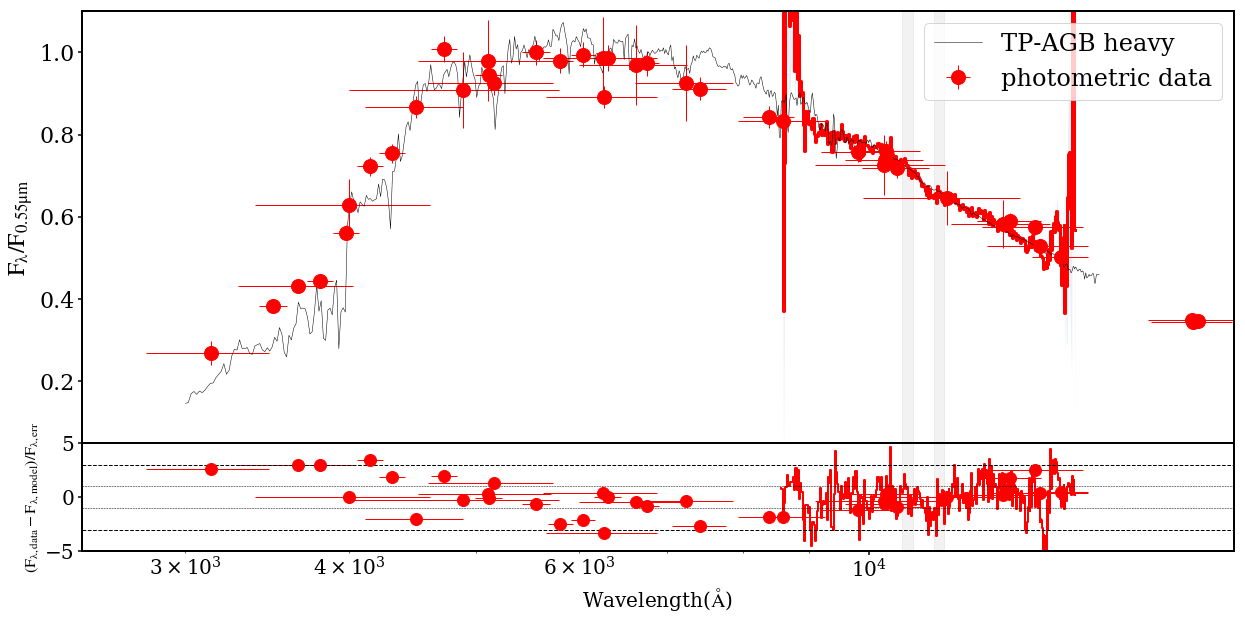

In [24]:
#--- Plot
X = sol.x
n = len(x)
fig1 = plt.figure(figsize=(20,10))
frame1 = fig1.add_axes((.1,.35,.8,.6))

plt.step(x, y, color='r',lw=3)
plt.fill_between(x,(y+y_err),(y-y_err),alpha=0.1)
plt.errorbar(wave_list, photometric_flux, xerr=band_list, yerr=photometric_flux_err, color='r', fmt='o', label='photometric data', markersize='14')

# CSP
model_wave =minimize_age_AV_vector_weighted_return_flux(X)[1]
model_flux =minimize_age_AV_vector_weighted_return_flux(X)[2]

model1_wave =minimize_age_AV_vector_weighted_return_flux(X)[1]
model1_flux =minimize_age_AV_vector_weighted_return_flux(X)[2]

plt.plot(model_wave, model_flux, color='k',label='TP-AGB heavy',lw=0.5)

plt.xlim([2.5e3,1.9e4])
plt.ylim([0.05, 1.1])
plt.semilogx()

plt.ylabel(r'$\rm F_{\lambda}/F_{0.55\mu m}$',fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc='upper right',fontsize=24)
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)

frame2 = fig1.add_axes((.1,.2,.8,.15))  
relative_spectra = np.zeros([1,n])
relative_spectra_err = np.zeros([1,n])
relative_sigma = np.zeros([1,n])
index0 = 0
for wave in x:
    if y[index0]>0.25 and y[index0]<1.35:
        index = find_nearest(model_wave, wave);#print index
        relative_spectra[0, index0] = y[index0]/model_flux[index]
        relative_spectra_err[0, index0] = y_err[index0]/model_flux[index]
        relative_sigma[0, index0] = (y[index0]-model_flux[index])/y_err[index0]
        index0 = index0+1
# plt.step(x[:index0], relative_spectra[0,:index0], color='r', linewidth=2)
# plt.fill_between(x[:index0],(relative_spectra[0,:index0]+relative_spectra_err[0,:index0]),\
#     (relative_spectra[0,:index0]-relative_spectra_err[0,:index0]),alpha=0.1)
plt.step(x[:index0], relative_sigma[0,:index0], color='r', linewidth=2)
# print(relative_sigma[0,:index0])
index0 = 0
# relative_photo = np.zeros([1,(len(wave_list))])
for i in range(len(wave_list)):
    try:
        index = find_nearest(model_wave, wave_list[i])
        # relative_photo[0, index0] = model_flux[index]/(photometric_flux[i])
    except:
        pass
    plt.errorbar(wave_list[i], (photometric_flux[i]-model_flux[index])/photometric_flux_err[i], xerr=band_list[i], fmt='o', color='r', markersize=12)
    # plt.errorbar(wave_list[i], (photometric_flux[i])/model_flux[index], xerr=band_list[i], yerr=photometric_flux_err[i]/model_flux[index], fmt='o', color='r', markersize=16)
    index0 = index0+1
plt.xlim([2.5e3,1.9e4])
plt.semilogx()
# plt.axhline(1.0, linestyle='--', linewidth=2, color='k')
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)
# plt.ylim([0.9,1.1])
# plt.ylim([0.7,1.45])
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.axhline(3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(-3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(1.0, linestyle='--', linewidth=0.5, color='k')
plt.axhline(-1.0, linestyle='--', linewidth=0.5, color='k')
plt.ylim([-5,5])
plt.ylabel(r'$\rm (F_{\lambda,\rm data}-F_{\lambda,\rm model})/F_{\lambda,\rm err}$',fontsize=16)
plt.xlabel(r'Wavelength($\rm \AA$)', fontsize=20)

### 1.1 Run with the MCMC

In [10]:
with Pool() as pool:
    ndim, nwalkers = 2, 10
    tik = time.clock()
    X = sol.x
    p0 = [sol.x + 4.*np.random.rand(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lg_minimize_age_AV_vector_weighted, pool=pool)
    sampler.run_mcmc(p0, nsteps, progress=True)
    samples = sampler.chain[:, 500:, :].reshape((-1,ndim))
    samples = samples[(samples[:,0] > age_prior_optimized*0.1) &
                      (samples[:,0] < age_prior_optimized*2.0) & 
                      (samples[:,1] < AV_prior_optimized*3.0)]            
    tok = time.clock()
    multi_time = tok-tik
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    print('Time to run M05 MCMC:'+str(tok-tik)) 

3.0.2


/Users/siqiliu/anaconda3/envs/py37/lib/python3.6/site-packages/ipykernel_launcher.py:485: RuntimeWarning: divide by zero encountered in log
/Users/siqiliu/anaconda3/envs/py37/lib/python3.6/site-packages/ipykernel_launcher.py:485: RuntimeWarning: divide by zero encountered in log
/Users/siqiliu/anaconda3/envs/py37/lib/python3.6/site-packages/ipykernel_launcher.py:485: RuntimeWarning: divide by zero encountered in log
/Users/siqiliu/anaconda3/envs/py37/lib/python3.6/site-packages/ipykernel_launcher.py:485: RuntimeWarning: divide by zero encountered in log
  0%|          | 0/1200 [00:00<?, ?it/s]/Users/siqiliu/anaconda3/envs/py37/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 2/1200 [00:00<07:04,  2.82it/s]/Users/siqiliu/anaconda3/envs/py37/lib/python3.6/site-packages/ipykernel_launcher.py:485: RuntimeWarning: divide by zero encountered in log
/Users/siqiliu/anacon

Multiprocessing took 8.6 seconds
Time to run M05 MCMC:8.575668


#### 1.1.1 Make corner plot of the MCMC result

MCMC results maximum Likelihood Point M05: [3.44013388 0.18328928] [1.50545482 0.09934387]


<Figure size 3200x3200 with 0 Axes>

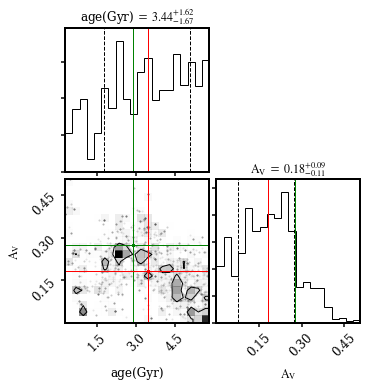

In [12]:
if samples.size > 1e3:
    value2 = np.percentile(samples, 50, axis=0)
    [std_age_prior_optimized, std_AV_prior_optimized] = np.std(samples, axis=0)
    plt.figure(figsize=(32,32),dpi=100)
    fig = corner.corner(samples,
         labels=["age(Gyr)", r"$\rm A_V$"],
         truths=[age_prior_optimized, AV_prior_optimized],
         levels = (1-np.exp(-0.5),),
         show_titles=True,
         title_kwargs={'fontsize':12},
         quantiles=(0.16,0.5, 0.84))
    axes = np.array(fig.axes).reshape((ndim, ndim))

    for i in range(ndim):
        ax = axes[i, i]
        ax.axvline(X[i], color="g")
        ax.axvline(value2[i],color='r')
    # Loop over the histograms
    for yi in range(ndim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.axvline(X[xi], color="g")
            ax.axvline(value2[xi], color="r")
            ax.axhline(X[yi], color="g")
            ax.axhline(value2[yi], color="r")
            ax.plot(X[xi], X[yi], "sg")
            ax.plot(value2[xi],value2[yi],'sr')
    plt.rcParams.update({'font.size': 12})
    print('MCMC results maximum Likelihood Point M05:', np.percentile(samples, 50, axis=0), np.std(samples, axis=0))

#### 1.1.2 Plot the SED with the MCMC 50 percentile result

In [23]:
#--- Plot
X = np.percentile(samples, 50, axis=0)
x2_optimized = minimize_age_AV_vector_weighted(X)
x2_spec, x2_phot = minimize_age_AV_vector_weighted_return_chi2_sep(X)
chi_square_list.loc[row,'M05_age_MCMC50'] = X[0]#"{0:.2f}".format(X[0])
chi_square_list.loc[row,'M05_AV_MCMC50'] = X[1]#"{0:.2f}".format(X[1])
chi_square_list.loc[row,'x2_M05_MCMC50'] = x2_optimized
chi_square_list.loc[row,'x2_spectra_M05_MCMC50'] = x2_spec
chi_square_list.loc[row,'x2_photo_M05_MCMC50'] = x2_phot
chi_square_list.loc[row,'M05_age_std'] = np.std(samples, axis=0)[0]#"{0:.2f}".format(np.std(samples, axis=0)[0])
chi_square_list.loc[row,'M05_AV_std'] = np.std(samples, axis=0)[1]#"{0:.2f}".format(np.std(samples, axis=0)[1])

n = len(x)
fig1 = plt.figure(figsize=(20,10))
frame1 = fig1.add_axes((.1,.35,.8,.6))
plt.step(x, y, color='r',lw=3)
plt.fill_between(x,(y+y_err),(y-y_err),alpha=0.1)
plt.errorbar(wave_list, photometric_flux, xerr=band_list, yerr=photometric_flux_err, color='r', fmt='o', label='photometric data', markersize='14')

model_wave =minimize_age_AV_vector_weighted_return_flux(X)[1]
model_flux =minimize_age_AV_vector_weighted_return_flux(X)[2]

plt.plot(model_wave, model_flux, color='k',label='TP-AGB heavy',lw=0.5)

plt.xlim([2.5e3,1.9e4])
plt.ylim([0.05, 1.1])#plt.ylim([ymin,ymax])
plt.semilogx()
plt.ylabel(r'$\rm F_{\lambda}/F_{0.55\mu m}$',fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc='upper right',fontsize=24)
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)

frame2 = fig1.add_axes((.1,.2,.8,.15))  
relative_spectra = np.zeros([1,n])
relative_spectra_err = np.zeros([1,n])
relative_sigma = np.zeros([1,n])
index0 = 0
for wave in x:
    if y[index0]>0.25 and y[index0]<1.35:
        index = find_nearest(model_wave, wave);#print index
        relative_spectra[0, index0] = y[index0]/model_flux[index]
        relative_spectra_err[0, index0] = y_err[index0]/model_flux[index]
        relative_sigma[0, index0] = (y[index0]-model_flux[index])/y_err[index0]
        index0 = index0+1
# plt.step(x[:index0], relative_spectra[0,:index0], color='r', linewidth=2)
# plt.fill_between(x[:index0],(relative_spectra[0,:index0]+relative_spectra_err[0,:index0]),\
#     (relative_spectra[0,:index0]-relative_spectra_err[0,:index0]),alpha=0.1)
plt.step(x[:index0], relative_sigma[0,:index0], color='r', linewidth=2)
# print(relative_sigma[0,:index0])
index0 = 0
# relative_photo = np.zeros([1,(len(wave_list))])
for i in range(len(wave_list)):
    try:
        index = find_nearest(model_wave, wave_list[i])
        # relative_photo[0, index0] = model_flux[index]/(photometric_flux[i])
    except:
        pass
    plt.errorbar(wave_list[i], (photometric_flux[i]-model_flux[index])/photometric_flux_err[i], xerr=band_list[i], fmt='o', color='r', markersize=12)
    # plt.errorbar(wave_list[i], (photometric_flux[i])/model_flux[index], xerr=band_list[i], yerr=photometric_flux_err[i]/model_flux[index], fmt='o', color='r', markersize=16)
    index0 = index0+1
plt.xlim([2.5e3,1.9e4])
plt.semilogx()
# plt.axhline(1.0, linestyle='--', linewidth=2, color='k')
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
# plt.ylim([0.9,1.1])
# plt.ylim([0.7,1.45])
plt.axhline(3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(-3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(1.0, linestyle='--', linewidth=0.5, color='k')
plt.axhline(-1.0, linestyle='--', linewidth=0.5, color='k')
plt.ylim([-5,5])
plt.ylabel(r'$\rm (F_{\lambda,\rm data}-F_{\lambda,\rm model})/F_{\lambda,\rm err}$',fontsize=16)
plt.xlabel(r'Wavelength($\rm \AA$)', fontsize=20)

NameError: name 'samples' is not defined

#### 1.1.3 If sampling points not enough, try with a longer nsteps (skipped if with enough samples) and plot SED

In [ ]:
with Pool() as pool:
    ndim, nwalkers = 2, 10
    tik = time.clock()
    X = sol.x
    p0 = [sol.x + 4.*np.random.rand(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lg_minimize_age_AV_vector_weighted, pool=pool)
    sampler.run_mcmc(p0, nsteps*2, progress=True)
    samples = sampler.chain[:, 500:, :].reshape((-1,ndim))
    samples = samples[(samples[:,0] > age_prior_optimized*0.1) &
                      (samples[:,0] < age_prior_optimized*2.0) & 
                      (samples[:,1] < AV_prior_optimized*3.0)]            
    tok = time.clock()
    multi_time = tok-tik
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    print('Time to run M05 MCMC:'+str(tok-tik))
if samples.size > 1e3:
    value2 = np.percentile(samples, 50, axis=0)
    [std_age_prior_optimized, std_AV_prior_optimized] = np.std(samples, axis=0)
    plt.figure(figsize=(32,32),dpi=100)
    fig = corner.corner(samples,
         labels=["age(Gyr)", r"$\rm A_V$"],
         truths=[age_prior_optimized, AV_prior_optimized],
         levels = (1-np.exp(-0.5),),
         show_titles=True,
         title_kwargs={'fontsize':12},
         quantiles=(0.16,0.5, 0.84))
    axes = np.array(fig.axes).reshape((ndim, ndim))

    for i in range(ndim):
        ax = axes[i, i]
        ax.axvline(X[i], color="g")
        ax.axvline(value2[i],color='r')
    # Loop over the histograms
    for yi in range(ndim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.axvline(X[xi], color="g")
            ax.axvline(value2[xi], color="r")
            ax.axhline(X[yi], color="g")
            ax.axhline(value2[yi], color="r")
            ax.plot(X[xi], X[yi], "sg")
            ax.plot(value2[xi],value2[yi],'sr')
    plt.rcParams.update({'font.size': 12})
    X = np.percentile(samples, 50, axis=0)
    x2_optimized = minimize_age_AV_vector_weighted(X)
    x2_spec, x2_phot = minimize_age_AV_vector_weighted_return_chi2_sep(X)
    chi_square_list.loc[row,'M05_age_MCMC50'] = X[0]#"{0:.2f}".format(X[0])
    chi_square_list.loc[row,'M05_AV_MCMC50'] = X[1]#"{0:.2f}".format(X[1])
    chi_square_list.loc[row,'x2_M05_MCMC50'] = x2_optimized
    chi_square_list.loc[row,'x2_spectra_M05_MCMC50'] = x2_spec
    chi_square_list.loc[row,'x2_photo_M05_MCMC50'] = x2_phot
    chi_square_list.loc[row,'M05_age_std'] = np.std(samples, axis=0)[0]#"{0:.2f}".format(np.std(samples, axis=0)[0])
    chi_square_list.loc[row,'M05_AV_std'] = np.std(samples, axis=0)[1]#"{0:.2f}".format(np.std(samples, axis=0)[1])

    n = len(x)
    fig1 = plt.figure(figsize=(20,10))
    frame1 = fig1.add_axes((.1,.35,.8,.6))
    plt.step(x, y, color='r',lw=3)
    plt.fill_between(x,(y+y_err),(y-y_err),alpha=0.1)
    plt.errorbar(wave_list, photometric_flux, xerr=band_list, yerr=photometric_flux_err, color='r', fmt='o', label='photometric data', markersize='14')

    model_wave =minimize_age_AV_vector_weighted_return_flux(X)[1]
    model_flux =minimize_age_AV_vector_weighted_return_flux(X)[2]

    plt.plot(model_wave, model_flux, color='k',label='TP-AGB heavy',lw=0.5)

    plt.xlim([2.5e3,1.9e4])
    plt.ylim([0.05, 1.1])#plt.ylim([ymin,ymax])
    plt.semilogx()
    plt.ylabel(r'$\rm F_{\lambda}/F_{0.55\mu m}$',fontsize=24)
    plt.tick_params(axis='both', which='major', labelsize=22)
    plt.legend(loc='upper right',fontsize=24)
    plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
    plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)

    frame2 = fig1.add_axes((.1,.2,.8,.15))  
    relative_spectra = np.zeros([1,n])
    relative_spectra_err = np.zeros([1,n])
    relative_sigma = np.zeros([1,n])
    index0 = 0
    for wave in x:
        if y[index0]>0.25 and y[index0]<1.35:
            index = find_nearest(model_wave, wave);#print index
            relative_spectra[0, index0] = y[index0]/model_flux[index]
            relative_spectra_err[0, index0] = y_err[index0]/model_flux[index]
            relative_sigma[0, index0] = (y[index0]-model_flux[index])/y_err[index0]
            index0 = index0+1
    # plt.step(x[:index0], relative_spectra[0,:index0], color='r', linewidth=2)
    # plt.fill_between(x[:index0],(relative_spectra[0,:index0]+relative_spectra_err[0,:index0]),\
    #     (relative_spectra[0,:index0]-relative_spectra_err[0,:index0]),alpha=0.1)
    plt.step(x[:index0],relative_sigma[0,:index0], color='r', linewidth=2)
    # print(relative_sigma[0,:index0])
    index0 = 0
    # relative_photo = np.zeros([1,(len(wave_list))])
    for i in range(len(wave_list)):
        try:
            index = find_nearest(model_wave, wave_list[i])
            # relative_photo[0, index0] = model_flux[index]/(photometric_flux[i])
        except:
            pass
        plt.errorbar(wave_list[i], (photometric_flux[i]-model_flux[index])/photometric_flux_err[i], xerr=band_list[i], fmt='o', color='r', markersize=12)
        # plt.errorbar(wave_list[i], (photometric_flux[i])/model_flux[index], xerr=band_list[i], yerr=photometric_flux_err[i]/model_flux[index], fmt='o', color='r', markersize=16)
        index0 = index0+1
    plt.xlim([2.5e3,1.9e4])
    plt.semilogx()
    # plt.axhline(1.0, linestyle='--', linewidth=2, color='k')
    plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
    plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.tick_params(axis='both', which='minor', labelsize=20)
    # plt.ylim([0.9,1.1])
    # plt.ylim([0.7,1.45])
    plt.axhline(3.0, linestyle='--', linewidth=1, color='k')
    plt.axhline(-3.0, linestyle='--', linewidth=1, color='k')
    plt.axhline(1.0, linestyle='--', linewidth=0.5, color='k')
    plt.axhline(-1.0, linestyle='--', linewidth=0.5, color='k')
    plt.ylim([-5,5])
    plt.ylabel(r'$\rm (F_{\lambda,\rm data}-F_{\lambda,\rm model})/F_{\lambda,\rm err}$',fontsize=16)
    plt.xlabel(r'Wavelength($\rm \AA$)', fontsize=20)

## 2 Test with M13 model

### 2.0 Find the optimized result

In [11]:
print('____________________M13_________________________ Optimization__________________________')
bnds = ((0.0, 13.0), (0.0, 4.0))
X = np.array([galaxy_age,intrinsic_Av])
sol_M13 = optimize.minimize(minimize_age_AV_vector_weighted_M13, X, bounds = bnds, method='TNC')#, options = {'disp': True})
# print('Optimized M13 weighted reduced chisqure result:', sol_M13)
[age_prior_optimized_M13, AV_prior_optimized_M13] = sol_M13.x
X = sol_M13.x
x2_optimized = minimize_age_AV_vector_weighted_M13(X)
x2_spec, x2_phot = minimize_age_AV_vector_weighted_M13_return_chi2_sep(X)
chi_square_list.loc[row,'M13_age_opt'] = X[0]#"{0:.2f}".format(X[0])
chi_square_list.loc[row,'M13_AV_opt'] = X[1]#"{0:.2f}".format(X[1])
chi_square_list.loc[row,'x2_M13_opt'] = x2_optimized
chi_square_list.loc[row,'x2_spectra_M13_opt'] = x2_spec
chi_square_list.loc[row,'x2_photo_M13_opt'] = x2_phot

____________________M13_________________________ Optimization__________________________


#### 2.0.1 Plot the SED

Text(0.5, 0, 'Wavelength($\\rm \\AA$)')

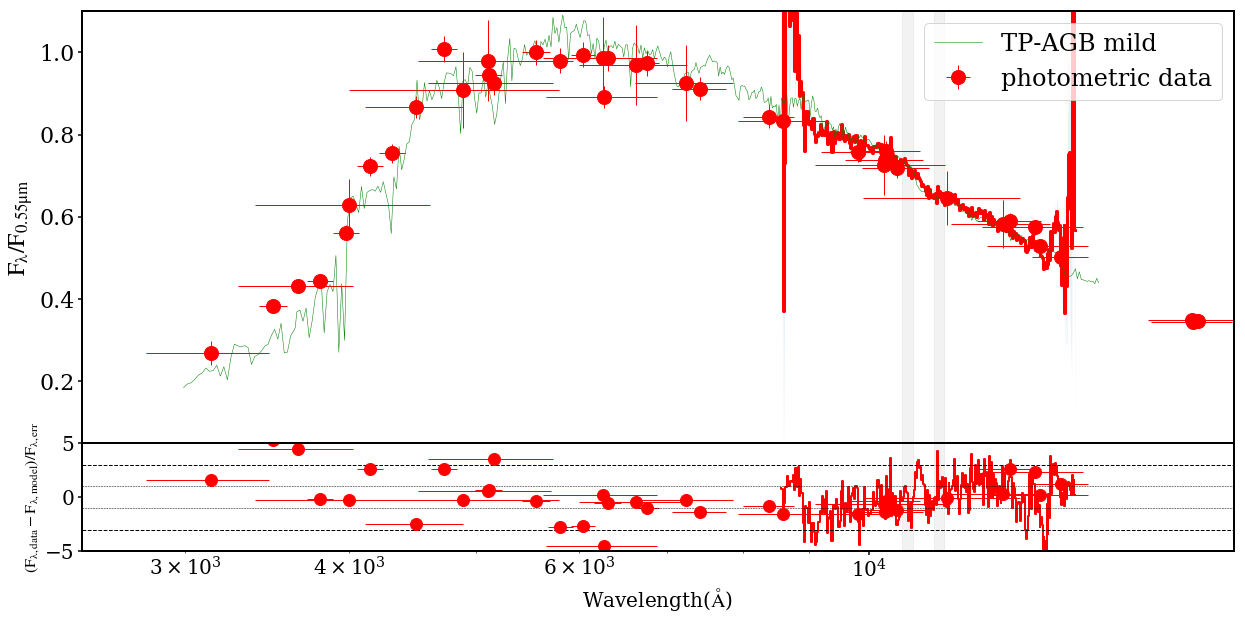

In [25]:
#--- Plot
X = sol_M13.x
n = len(x)
fig1 = plt.figure(figsize=(20,10))
frame1 = fig1.add_axes((.1,.35,.8,.6))
plt.step(x, y, color='r',lw=3)
plt.fill_between(x,(y+y_err),(y-y_err),alpha=0.1)
plt.errorbar(wave_list, photometric_flux, xerr=band_list, yerr=photometric_flux_err, color='r', fmt='o', label='photometric data', markersize='14')

model_wave =minimize_age_AV_vector_weighted_M13_return_flux(X)[1]
model_flux =minimize_age_AV_vector_weighted_M13_return_flux(X)[2]

model2_wave =minimize_age_AV_vector_weighted_M13_return_flux(X)[1]
model2_flux =minimize_age_AV_vector_weighted_M13_return_flux(X)[2]

plt.plot(model_wave, model_flux, color='g',label='TP-AGB mild',lw=0.5)

plt.xlim([2.5e3,1.9e4])
plt.ylim([0.05, 1.1])#plt.ylim([ymin,ymax])
plt.semilogx()

plt.ylabel(r'$\rm F_{\lambda}/F_{0.55\mu m}$',fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc='upper right',fontsize=24)
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)

frame2 = fig1.add_axes((.1,.2,.8,.15))  
relative_spectra = np.zeros([1,n])
relative_spectra_err = np.zeros([1,n])
relative_sigma = np.zeros([1,n])
index0 = 0
for wave in x:
    if y[index0]>0.25 and y[index0]<1.35:
        index = find_nearest(model_wave, wave);#print index
        relative_spectra[0, index0] = y[index0]/model_flux[index]
        relative_spectra_err[0, index0] = y_err[index0]/model_flux[index]
        relative_sigma[0, index0] = (y[index0]-model_flux[index])/y_err[index0]
        index0 = index0+1
# plt.step(x[:index0], relative_spectra[0,:index0], color='r', linewidth=2)
# plt.fill_between(x[:index0],(relative_spectra[0,:index0]+relative_spectra_err[0,:index0]),\
#     (relative_spectra[0,:index0]-relative_spectra_err[0,:index0]),alpha=0.1)
plt.step(x[:index0], relative_sigma[0,:index0], color='r', linewidth=2)

index0 = 0
# relative_photo = np.zeros([1,(len(wave_list))])
for i in range(len(wave_list)):
    try:
        index = find_nearest(model_wave, wave_list[i])
        # relative_photo[0, index0] = model_flux[index]/(photometric_flux[i])
    except:
        pass
    plt.errorbar(wave_list[i], (photometric_flux[i]-model_flux[index])/photometric_flux_err[i], xerr=band_list[i], fmt='o', color='r', markersize=12)
    # plt.errorbar(wave_list[i], (photometric_flux[i])/model_flux[index], xerr=band_list[i], yerr=photometric_flux_err[i]/model_flux[index], fmt='o', color='r', markersize=16)
    index0 = index0+1
plt.xlim([2.5e3,1.9e4])
plt.semilogx()
# plt.axhline(1.0, linestyle='--', linewidth=2, color='k')
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
# plt.ylim([0.75,1.5])
# plt.ylim([0.9,1.1])
# plt.ylim([0.7,1.45])
plt.axhline(3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(-3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(1.0, linestyle='--', linewidth=0.5, color='k')
plt.axhline(-1.0, linestyle='--', linewidth=0.5, color='k')
plt.ylim([-5,5])
plt.ylabel(r'$\rm (F_{\lambda,\rm data}-F_{\lambda,\rm model})/F_{\lambda,\rm err}$',fontsize=16)
plt.xlabel(r'Wavelength($\rm \AA$)', fontsize=20)

### 2.1 Running MCMC

In [17]:
with Pool() as pool:
    ndim, nwalkers = 2, 10
    tik = time.clock()
    p0 = [sol_M13.x + 4.*np.random.rand(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lg_minimize_age_AV_vector_weighted_M13, pool=pool)
    sampler.run_mcmc(p0,nsteps,progress=True)
    samples = sampler.chain[:, 500:, :].reshape((-1,ndim))
    samples = samples[(samples[:,0] > age_prior_optimized_M13*0.1) & (samples[:,0] < age_prior_optimized_M13*2.0) & (samples[:,1] < AV_prior_optimized_M13*3.0)]
    tok = time.clock()
    multi_time = tok-tik
    print("Multiprocessing took {0:.1f} seconds".format(multi_time)) 
    print('Time to run M13 MCMC:'+str(tok-tik))

100%|██████████| 1200/1200 [06:11<00:00,  3.23it/s]


Multiprocessing took 8.2 seconds
Time to run M13 MCMC:8.187416999999996


#### 2.1.1 Make corner plot with the samples

Maximum Likelihood Point M13: [1.60335717 0.49524279] [0.90500782 0.30467984]


<Figure size 3200x3200 with 0 Axes>

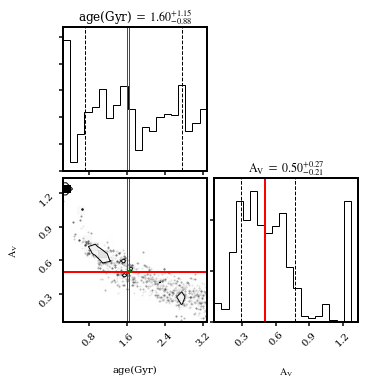

In [18]:
if samples.size > 1e3 :
    value2 = np.percentile(samples,50,axis=0)
    [std_age_prior_optimized_M13, std_AV_prior_optimized_M13] = np.std(samples, axis=0)
    plt.figure(figsize=(32,32),dpi=100)
    fig = corner.corner(samples,
         labels=["age(Gyr)", r"$\rm A_V$"],
         levels=(1-np.exp(-0.5),),
         truths=[age_prior_optimized_M13, AV_prior_optimized_M13],
         show_titles=True,title_kwargs={'fontsize':12},
                        quantiles=(0.16,0.5, 0.84))
    axes = np.array(fig.axes).reshape((ndim, ndim))
    for i in range(ndim):
        ax = axes[i, i]
        ax.axvline(X[i], color="g")
        ax.axvline(value2[i],color='r')
    # Loop over the histograms
    for yi in range(ndim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.axvline(X[xi], color="g")
            ax.axvline(value2[xi], color="r")
            ax.axhline(X[yi], color="g")
            ax.axhline(value2[yi], color="r")
            ax.plot(X[xi], X[yi], "sg")
            ax.plot(value2[xi],value2[yi],'sr')
    plt.rcParams.update({'font.size': 12})
    print('Maximum Likelihood Point M13:', np.percentile(samples, 50, axis=0), np.std(samples, axis=0))

#### 2.1.2 Plot the SED

Text(0.5, 0, 'Wavelength($\\rm \\AA$)')

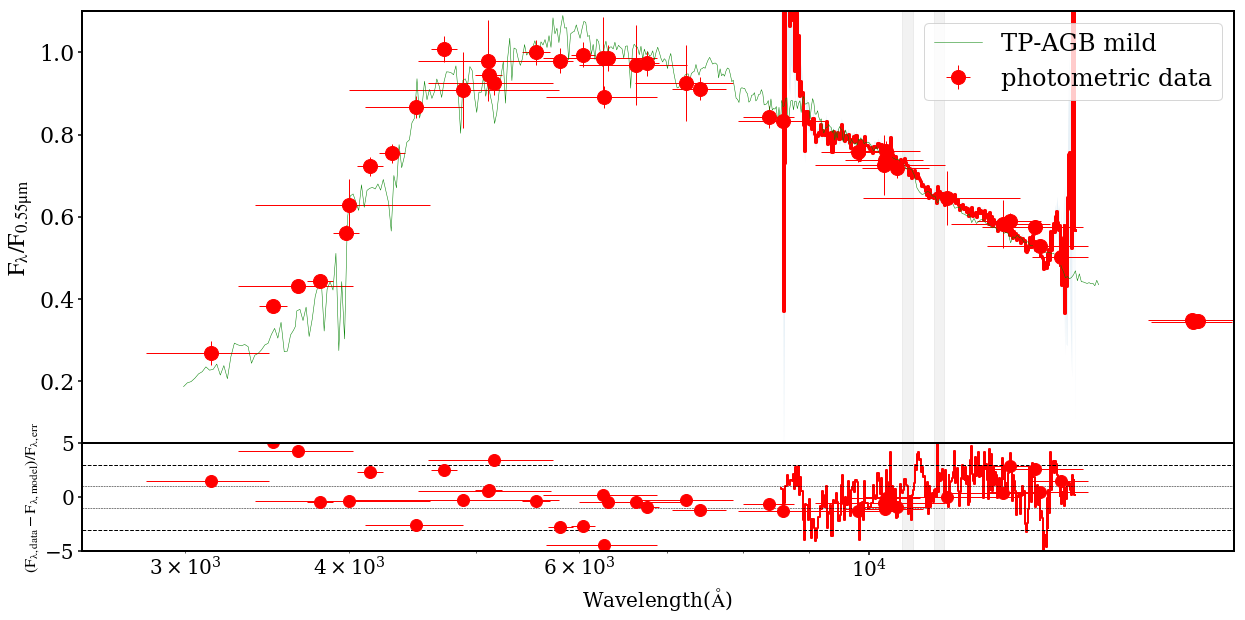

In [19]:
#--- Plot
X = np.percentile(samples, 50, axis=0)
x2_optimized = minimize_age_AV_vector_weighted_M13(X)
x2_spec, x2_phot = minimize_age_AV_vector_weighted_M13_return_chi2_sep(X)
chi_square_list.loc[row,'M13_age_MCMC50'] = X[0]#"{0:.2f}".format(X[0])
chi_square_list.loc[row,'M13_AV_MCMC50'] = X[1]#"{0:.2f}".format(X[1])
chi_square_list.loc[row,'x2_M13_MCMC50'] = x2_optimized
chi_square_list.loc[row,'x2_spectra_M13_MCMC50'] = x2_spec
chi_square_list.loc[row,'x2_photo_M13_MCMC50'] = x2_phot
chi_square_list.loc[row,'M13_age_std'] = np.std(samples, axis=0)[0]#"{0:.2f}".format(np.std(samples, axis=0)[0])
chi_square_list.loc[row,'M13_AV_std'] = np.std(samples, axis=0)[1]#"{0:.2f}".format(np.std(samples, axis=0)[1])

n = len(x)
fig1 = plt.figure(figsize=(20,10))
frame1 = fig1.add_axes((.1,.35,.8,.6))
plt.step(x, y, color='r',lw=3)
plt.fill_between(x,(y+y_err),(y-y_err),alpha=0.1)
plt.errorbar(wave_list, photometric_flux, xerr=band_list, yerr=photometric_flux_err, color='r', fmt='o', label='photometric data', markersize='14')
model_wave =minimize_age_AV_vector_weighted_M13_return_flux(X)[1]
model_flux =minimize_age_AV_vector_weighted_M13_return_flux(X)[2]
plt.plot(model_wave, model_flux, color='g',label='TP-AGB mild',lw=0.5)
plt.xlim([2.5e3,1.9e4])
plt.ylim([0.05, 1.1])#plt.ylim([ymin,ymax])
plt.semilogx()
plt.ylabel(r'$\rm F_{\lambda}/F_{0.55\mu m}$',fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc='upper right',fontsize=24)
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)

frame2 = fig1.add_axes((.1,.2,.8,.15))  
relative_spectra = np.zeros([1,n])
relative_spectra_err = np.zeros([1,n])
relative_sigma = np.zeros([1,n])
index0 = 0
for wave in x:
    if y[index0]>0.25 and y[index0]<1.35:
        index = find_nearest(model_wave, wave);#print index
        relative_spectra[0, index0] = y[index0]/model_flux[index]
        relative_spectra_err[0, index0] = y_err[index0]/model_flux[index]
        relative_sigma[0, index0] = (y[index0]-model_flux[index])/y_err[index0]
        index0 = index0+1
# plt.step(x[:index0], relative_spectra[0,:index0], color='r', linewidth=2)
# plt.fill_between(x[:index0],(relative_spectra[0,:index0]+relative_spectra_err[0,:index0]),\
#     (relative_spectra[0,:index0]-relative_spectra_err[0,:index0]),alpha=0.1)
plt.step(x[:index0], relative_sigma[0,:index0], color='r', linewidth=2)
index0 = 0
# relative_photo = np.zeros([1,(len(wave_list))])
for i in range(len(wave_list)):
    try:
        index = find_nearest(model_wave, wave_list[i])
        # relative_photo[0, index0] = model_flux[index]/(photometric_flux[i])
    except:
        pass
    # plt.errorbar(wave_list[i], (photometric_flux[i])/model_flux[index], xerr=band_list[i], yerr=photometric_flux_err[i]/model_flux[index], fmt='o', color='r', markersize=16)
    plt.errorbar(wave_list[i], (photometric_flux[i]-model_flux[index])/photometric_flux_err[i], xerr=band_list[i], fmt='o', color='r', markersize=12)
    index0 = index0+1
plt.xlim([2.5e3,1.9e4])
plt.semilogx()
# plt.axhline(1.0, linestyle='--', linewidth=2, color='k')
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
# plt.ylim([0.75,1.5])
# plt.ylim([0.9,1.1])
# plt.ylim([0.7,1.45])
plt.axhline(3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(-3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(1.0, linestyle='--', linewidth=0.5, color='k')
plt.axhline(-1.0, linestyle='--', linewidth=0.5, color='k')
plt.ylim([-5,5])
plt.ylabel(r'$\rm (F_{\lambda,\rm data}-F_{\lambda,\rm model})/F_{\lambda,\rm err}$',fontsize=16)
plt.xlabel(r'Wavelength($\rm \AA$)', fontsize=20)

#### 2.2.3 If not enough samples, run with a longer nsteps

In [ ]:
with Pool() as pool:
    ndim, nwalkers = 2, 10
    tik = time.clock()
    p0 = [sol_M13.x + 4.*np.random.rand(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lg_minimize_age_AV_vector_weighted_M13, pool=pool)
    sampler.run_mcmc(p0,nsteps*2,progress=True)
    samples = sampler.chain[:, 500:, :].reshape((-1,ndim))
    samples = samples[(samples[:,0] > age_prior_optimized_M13*0.1) & (samples[:,0] < age_prior_optimized_M13*2.0) & (samples[:,1] < AV_prior_optimized_M13*3.0)]
    tok = time.clock()
    multi_time = tok-tik
    print("Multiprocessing took {0:.1f} seconds".format(multi_time)) 
    print('Time to run M13 MCMC:'+str(tok-tik))
if samples.size > 1e3 :
    value2 = np.percentile(samples,50,axis=0)
    [std_age_prior_optimized_M13, std_AV_prior_optimized_M13] = np.std(samples, axis=0)
    plt.figure(figsize=(32,32),dpi=100)
    fig = corner.corner(samples,
         labels=["age(Gyr)", r"$\rm A_V$"],
         levels=(1-np.exp(-0.5),),
         truths=[age_prior_optimized_M13, AV_prior_optimized_M13],
         show_titles=True,title_kwargs={'fontsize':12},
                        quantiles=(0.16,0.5, 0.84))
    axes = np.array(fig.axes).reshape((ndim, ndim))
    for i in range(ndim):
        ax = axes[i, i]
        ax.axvline(X[i], color="g")
        ax.axvline(value2[i],color='r')
    # Loop over the histograms
    for yi in range(ndim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.axvline(X[xi], color="g")
            ax.axvline(value2[xi], color="r")
            ax.axhline(X[yi], color="g")
            ax.axhline(value2[yi], color="r")
            ax.plot(X[xi], X[yi], "sg")
            ax.plot(value2[xi],value2[yi],'sr')
    plt.rcParams.update({'font.size': 12})
    
    #--- Plot
    X = np.percentile(samples, 50, axis=0)
    x2_optimized = minimize_age_AV_vector_weighted_M13(X)
    x2_spec, x2_phot = minimize_age_AV_vector_weighted_M13_return_chi2_sep(X)
    chi_square_list.loc[row,'M13_age_MCMC50'] = X[0]#"{0:.2f}".format(X[0])
    chi_square_list.loc[row,'M13_AV_MCMC50'] = X[1]#"{0:.2f}".format(X[1])
    chi_square_list.loc[row,'x2_M13_MCMC50'] = x2_optimized
    chi_square_list.loc[row,'x2_spectra_M13_MCMC50'] = x2_spec
    chi_square_list.loc[row,'x2_photo_M13_MCMC50'] = x2_phot
    chi_square_list.loc[row,'M13_age_std'] = np.std(samples, axis=0)[0]#"{0:.2f}".format(np.std(samples, axis=0)[0])
    chi_square_list.loc[row,'M13_AV_std'] = np.std(samples, axis=0)[1]#"{0:.2f}".format(np.std(samples, axis=0)[1])

    n = len(x)
    fig1 = plt.figure(figsize=(20,10))
    frame1 = fig1.add_axes((.1,.35,.8,.6))
    plt.step(x, y, color='r',lw=3)
    plt.fill_between(x,(y+y_err),(y-y_err),alpha=0.1)
    plt.errorbar(wave_list, photometric_flux, xerr=band_list, yerr=photometric_flux_err, color='r', fmt='o', label='photometric data', markersize='14')
    model_wave =minimize_age_AV_vector_weighted_M13_return_flux(X)[1]
    model_flux =minimize_age_AV_vector_weighted_M13_return_flux(X)[2]
    plt.plot(model_wave, model_flux, color='g',label='TP-AGB mild',lw=0.5)
    plt.xlim([2.5e3,1.9e4])
    plt.ylim([0.05, 1.1])#plt.ylim([ymin,ymax])
    plt.semilogx()
    plt.ylabel(r'$\rm F_{\lambda}/F_{0.55\mu m}$',fontsize=24)
    plt.tick_params(axis='both', which='major', labelsize=22)
    plt.legend(loc='upper right',fontsize=24)
    plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
    plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)

    frame2 = fig1.add_axes((.1,.2,.8,.15))  
    relative_spectra = np.zeros([1,n])
    relative_spectra_err = np.zeros([1,n])
    relative_sigma = np.zeros([1,n])
    index0 = 0
    for wave in x:
        if y[index0]>0.25 and y[index0]<1.35:
            index = find_nearest(model_wave, wave);#print index
            relative_spectra[0, index0] = y[index0]/model_flux[index]
            relative_spectra_err[0, index0] = y_err[index0]/model_flux[index]
            relative_sigma[0, index0] = (y[index0]-model_flux[index])/y_err[index0]
            index0 = index0+1
    # plt.step(x[:index0], relative_spectra[0,:index0], color='r', linewidth=2)
    # plt.fill_between(x[:index0],(relative_spectra[0,:index0]+relative_spectra_err[0,:index0]),\
    #     (relative_spectra[0,:index0]-relative_spectra_err[0,:index0]),alpha=0.1)
    plt.step(x[:index0], relative_sigma[0,:index0], color='r', linewidth=2)
    # print(relative_sigma[0,:index0])
    index0 = 0
    # relative_photo = np.zeros([1,(len(wave_list))])
    for i in range(len(wave_list)):
        try:
            index = find_nearest(model_wave, wave_list[i])
            # relative_photo[0, index0] = model_flux[index]/(photometric_flux[i])
        except:
            pass
        plt.errorbar(wave_list[i], (photometric_flux[i]-model_flux[index])/photometric_flux_err[i], xerr=band_list[i], fmt='o', color='r', markersize=12)
        # plt.errorbar(wave_list[i], (photometric_flux[i])/model_flux[index], xerr=band_list[i], yerr=photometric_flux_err[i]/model_flux[index], fmt='o', color='r', markersize=16)
        index0 = index0+1
    plt.xlim([2.5e3,1.9e4])
    plt.semilogx()
    # plt.axhline(1.0, linestyle='--', linewidth=2, color='k')
    plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
    plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.tick_params(axis='both', which='minor', labelsize=20)
    # plt.ylim([0.75,1.5])
    # plt.ylim([0.9,1.1])
    # plt.ylim([0.7,1.45])
    plt.axhline(3.0, linestyle='--', linewidth=1, color='k')
    plt.axhline(-3.0, linestyle='--', linewidth=1, color='k')
    plt.axhline(1.0, linestyle='--', linewidth=0.5, color='k')
    plt.axhline(-1.0, linestyle='--', linewidth=0.5, color='k')
    plt.ylim([-5,5])
    plt.ylabel(r'$\rm (F_{\lambda,\rm data}-F_{\lambda,\rm model})/F_{\lambda,\rm err}$',fontsize=16)
    plt.xlabel(r'Wavelength($\rm \AA$)', fontsize=20)

## 3 Test with BC03

### 3.0 Optimization result

In [13]:
print('____________________BC03_________________________ Optimization__________________________')
bnds = ((0.0, 13.0), (0.0, 4.0))
X = np.array([galaxy_age,intrinsic_Av])
sol_BC03 = optimize.minimize(minimize_age_AV_vector_weighted_BC03, X, bounds = bnds, method='TNC')#, options = {'disp': True})
# print('Optimized BC03 weighted reduced chisqure result:', sol_BC03)
[age_prior_optimized_BC03, AV_prior_optimized_BC03] = sol_BC03.x
X = sol_BC03.x
x2_optimized = minimize_age_AV_vector_weighted_BC03(X)
x2_spec, x2_phot = minimize_age_AV_vector_weighted_BC03_return_chi2_sep(X)
chi_square_list.loc[row,'BC_age_opt'] = X[0]#"{0:.2f}".format(X[0])
chi_square_list.loc[row,'BC_AV_opt'] = X[1]#"{0:.2f}".format(X[1])
chi_square_list.loc[row,'x2_BC_opt'] = x2_optimized
chi_square_list.loc[row,'x2_spectra_BC_opt'] = x2_spec
chi_square_list.loc[row,'x2_photo_BC_opt'] = x2_phot


____________________BC03_________________________ Optimization__________________________


#### 3.0.1 Plot the SED

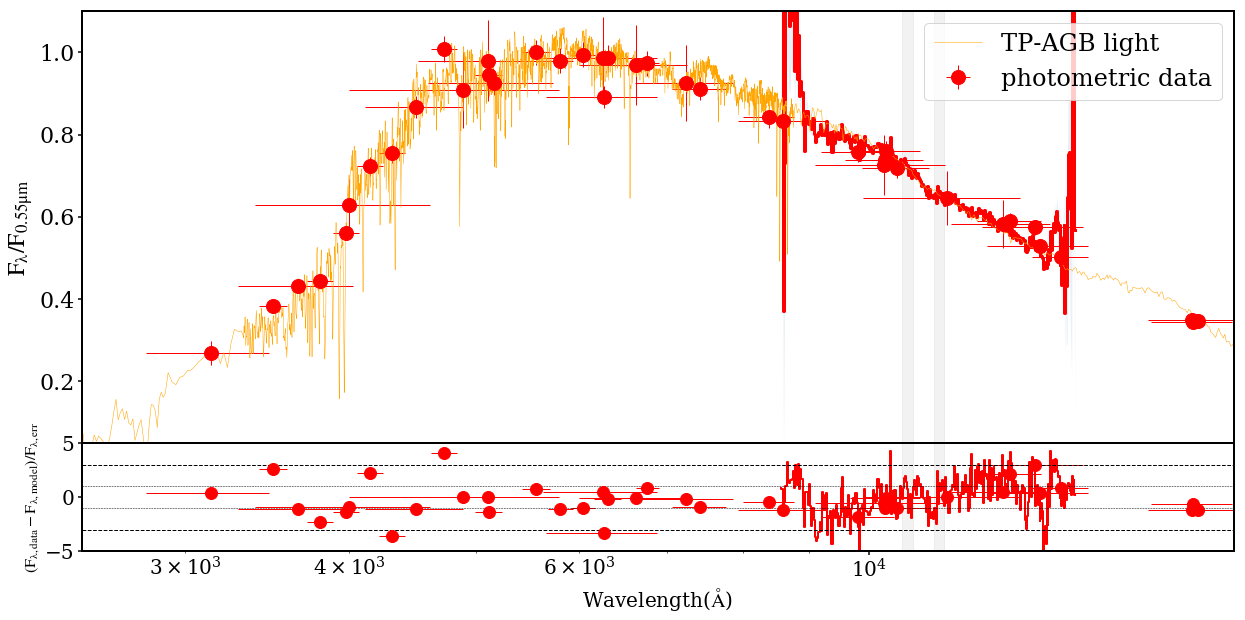

In [26]:
### Plot
X = sol_BC03.x
n = len(x)
fig1 = plt.figure(figsize=(20,10))
frame1 = fig1.add_axes((.1,.35,.8,.6))
plt.step(x, y, color='r',lw=3)
plt.fill_between(x,(y+y_err),(y-y_err),alpha=0.1)
plt.errorbar(wave_list, photometric_flux, xerr=band_list, yerr=photometric_flux_err, color='r', fmt='o', label='photometric data', markersize='14')
BC03_flux_attenuated = minimize_age_AV_vector_weighted_BC03_mod_no_weight_return_flux(X)[1]
plt.plot(BC03_wave_list_num, BC03_flux_attenuated, color='orange',label='TP-AGB light',lw=0.5)
model_wave = BC03_wave_list_num
model_flux = BC03_flux_attenuated
model3_wave = BC03_wave_list_num
model3_flux = BC03_flux_attenuated
plt.xlim([2.5e3,1.9e4])
plt.ylim([0.05, 1.1])#plt.ylim([ymin,ymax])
plt.semilogx()
plt.ylabel(r'$\rm F_{\lambda}/F_{0.55\mu m}$',fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc='upper right',fontsize=24)
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)

frame2 = fig1.add_axes((.1,.2,.8,.15))  
relative_spectra = np.zeros([1,n])
relative_spectra_err = np.zeros([1,n])
relative_sigma = np.zeros([1,n])
index0 = 0
for wave in x:
    if y[index0]>0.25 and y[index0]<1.35:
        index = find_nearest(model_wave, wave);#print index
        relative_spectra[0, index0] = y[index0]/model_flux[index]
        relative_spectra_err[0, index0] = y_err[index0]/model_flux[index]
        relative_sigma[0, index0] = (y[index0]-model_flux[index])/y_err[index0]
        index0 = index0+1
# plt.step(x[:index0], relative_spectra[0,:index0], color='r', linewidth=2)
# plt.fill_between(x[:index0],(relative_spectra[0,:index0]+relative_spectra_err[0,:index0]),\
#     (relative_spectra[0,:index0]-relative_spectra_err[0,:index0]),alpha=0.1)
plt.step(x[:index0], relative_sigma[0,:index0], color='r', linewidth=2)
# print(relative_sigma[0,:index0])
index0 = 0
# relative_photo = np.zeros([1,(len(wave_list))])
for i in range(len(wave_list)):
    try:
        index = find_nearest(model_wave, wave_list[i])
        # relative_photo[0, index0] = model_flux[index]/(photometric_flux[i])
    except:
        pass
    plt.errorbar(wave_list[i], (photometric_flux[i]-model_flux[index])/photometric_flux_err[i], xerr=band_list[i], fmt='o', color='r', markersize=12)
    # plt.errorbar(wave_list[i], (photometric_flux[i])/model_flux[index], xerr=band_list[i], yerr=photometric_flux_err[i]/model_flux[index], fmt='o', color='r', markersize=16)
    index0 = index0+1
plt.xlim([2.5e3,1.9e4])
plt.semilogx()
# plt.axhline(1.0, linestyle='--', linewidth=2, color='k')
# plt.ylim([0.6,1.5])
# plt.ylim([0.9,1.1])
# plt.ylim([0.7,1.45])
plt.axhline(3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(-3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(1.0, linestyle='--', linewidth=0.5, color='k')
plt.axhline(-1.0, linestyle='--', linewidth=0.5, color='k')
plt.ylim([-5,5])
plt.ylabel(r'$\rm (F_{\lambda,\rm data}-F_{\lambda,\rm model})/F_{\lambda,\rm err}$',fontsize=16)
plt.xlabel(r'Wavelength($\rm \AA$)', fontsize=20)
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)

### 3.1 Running MCMC

In [22]:
with Pool() as pool:
    ndim, nwalkers = 2, 10
    tik = time.process_time()
    X = sol_BC03.x
    p0 = [sol_BC03.x + 4.*np.random.rand(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lg_minimize_age_AV_vector_weighted_BC03, pool=pool)
    sampler.run_mcmc(p0, nsteps, progress=True)
    samples = sampler.chain[:, 500:, :].reshape((-1,ndim))
    samples = samples[(samples[:,0] > age_prior_optimized_BC03*0.1) & (samples[:,0] < age_prior_optimized_BC03*2.0) & (samples[:,1] < AV_prior_optimized_BC03*3.0)]
    tok = time.process_time()
    multi_time = tok-tik
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    print('Time to run BC03 MCMC:'+str(tok-tik))

100%|██████████| 1200/1200 [03:57<00:00,  5.05it/s]


Multiprocessing took 8.1 seconds
Time to run BC03 MCMC:8.095488999999986


#### 3.1.1 Corner plot of MCMC

<Figure size 3200x3200 with 0 Axes>

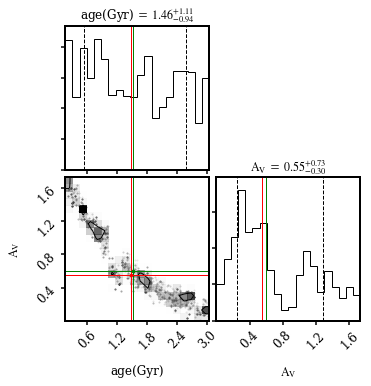

In [23]:
if samples.size > 1e3:
    value2 = np.percentile(samples,50,axis=0)
    [std_age_prior_optimized_BC03, std_AV_prior_optimized_BC03] = np.std(samples, axis=0)
    plt.figure(figsize=(32,32),dpi=100)
    fig = corner.corner(samples,
                        labels=["age(Gyr)", r"$\rm A_V$"],\
                        truths=[age_prior_optimized_BC03, AV_prior_optimized_BC03],\
                        levels = (1-np.exp(-0.5),),\
                        show_titles=True,title_kwargs={'fontsize':12},
                        quantiles=(0.16,0.5, 0.84))
    axes = np.array(fig.axes).reshape((ndim, ndim))
    for i in range(ndim):
        ax = axes[i, i]
        ax.axvline(X[i], color="g")
        ax.axvline(value2[i],color='r')
    # Loop over the histograms
    for yi in range(ndim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.axvline(X[xi], color="g")
            ax.axvline(value2[xi], color="r")
            ax.axhline(X[yi], color="g")
            ax.axhline(value2[yi], color="r")
            ax.plot(X[xi], X[yi], "sg")
            ax.plot(value2[xi],value2[yi],'sr')
    plt.rcParams.update({'font.size': 12})

#### 3.1.2 Plot the SED

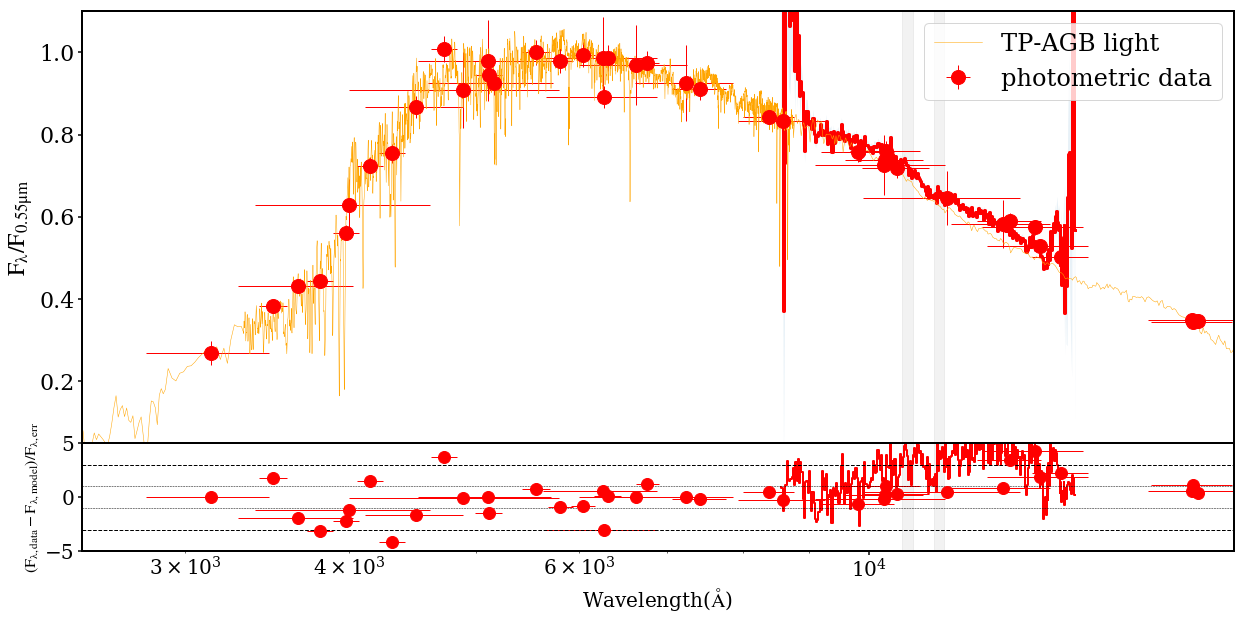

In [41]:
#--- Plot
X = np.percentile(samples, 50, axis=0)
x2_optimized = minimize_age_AV_vector_weighted_BC03(X)
x2_spec, x2_phot = minimize_age_AV_vector_weighted_BC03_return_chi2_sep(X)
chi_square_list.loc[row,'BC_age_MCMC50'] = X[0]#"{0:.2f}".format(X[0])
chi_square_list.loc[row,'BC_AV_MCMC50'] = X[1]#"{0:.2f}".format(X[1])
chi_square_list.loc[row,'x2_BC_MCMC50'] = x2_optimized
chi_square_list.loc[row,'x2_spectra_BC_MCMC50'] = x2_spec
chi_square_list.loc[row,'x2_photo_BC_MCMC50'] = x2_phot
chi_square_list.loc[row,'BC_age_std'] = np.std(samples, axis=0)[0]#"{0:.2f}".format(np.std(samples, axis=0)[0])
chi_square_list.loc[row,'BC_AV_std'] = np.std(samples, axis=0)[1]#"{0:.2f}".format(np.std(samples, axis=0)[1])
n = len(x)

fig1 = plt.figure(figsize=(20,10))
frame1 = fig1.add_axes((.1,.35,.8,.6))
plt.step(x, y, color='r',lw=3)
plt.fill_between(x,(y+y_err),(y-y_err),alpha=0.1)
plt.errorbar(wave_list, photometric_flux, xerr=band_list, yerr=photometric_flux_err, color='r', fmt='o', label='photometric data', markersize='14')
BC03_flux_attenuated = minimize_age_AV_vector_weighted_BC03_mod_no_weight_return_flux(X)[1]
plt.plot(BC03_wave_list_num, BC03_flux_attenuated, color='orange',label='TP-AGB light',lw=0.5)
model_wave = BC03_wave_list_num
model_flux = BC03_flux_attenuated
plt.xlim([2.5e3,1.9e4])
plt.ylim([0.05, 1.1])#plt.ylim([ymin,ymax])
plt.semilogx()
plt.ylabel(r'$\rm F_{\lambda}/F_{0.55\mu m}$',fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc='upper right',fontsize=24)
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)

frame2 = fig1.add_axes((.1,.2,.8,.15))  
relative_spectra = np.zeros([1,n])
relative_spectra_err = np.zeros([1,n])
relative_sigma = np.zeros([1,n])
index0 = 0
for wave in x:
    if y[index0]>0.25 and y[index0]<1.35:
        index = find_nearest(model_wave, wave);#print index
        relative_spectra[0, index0] = y[index0]/model_flux[index]
        relative_spectra_err[0, index0] = y_err[index0]/model_flux[index]
        relative_sigma[0, index0] = (y[index0]-model_flux[index])/y_err[index0]
        index0 = index0+1
plt.step(x[:index0], relative_sigma[0,:index0], color='r', linewidth=2)
plt.errorbar(wave_list[i], (photometric_flux[i]-model_flux[index])/photometric_flux_err[i], xerr=band_list[i], fmt='o', color='r', markersize=12)

index0 = 0
# relative_photo = np.zeros([1,(len(wave_list))])
for i in range(len(wave_list)):
    try:
        index = find_nearest(model_wave, wave_list[i])
        # relative_photo[0, index0] = model_flux[index]/(photometric_flux[i])
    except:
        pass
    plt.errorbar(wave_list[i], (photometric_flux[i]-model_flux[index])/photometric_flux_err[i], xerr=band_list[i], fmt='o', color='r', markersize=12)
    # plt.errorbar(wave_list[i], (photometric_flux[i])/model_flux[index], xerr=band_list[i], yerr=photometric_flux_err[i]/model_flux[index], fmt='o', color='r', markersize=16)
    index0 = index0+1
plt.xlim([2.5e3,1.9e4])
plt.semilogx()
# plt.axhline(1.0, linestyle='--', linewidth=2, color='k')
# plt.ylim([0.6,1.5])
# plt.ylim([0.9,1.1])
# plt.ylim([0.7,1.45])
plt.axhline(3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(-3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(1.0, linestyle='--', linewidth=0.5, color='k')
plt.axhline(-1.0, linestyle='--', linewidth=0.5, color='k')
plt.ylim([-5,5])
plt.ylabel(r'$\rm (F_{\lambda,\rm data}-F_{\lambda,\rm model})/F_{\lambda,\rm err}$',fontsize=16)
plt.xlabel(r'Wavelength($\rm \AA$)', fontsize=20)
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)

#### 3.1.3 If not enough samples, run with a longer steps 

In [ ]:
with Pool() as pool:
    ndim, nwalkers = 2, 10
    tik = time.clock()
    X = sol_BC03.x
    p0 = [sol_BC03.x + 4.*np.random.rand(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lg_minimize_age_AV_vector_weighted_BC03, pool=pool)
    sampler.run_mcmc(p0, nsteps*2, progress=True)
    samples = sampler.chain[:, 500:, :].reshape((-1,ndim))
    samples = samples[(samples[:,0] > age_prior_optimized_BC03*0.1) & (samples[:,0] < age_prior_optimized_BC03*2.0) & (samples[:,1] < AV_prior_optimized_BC03*3.0)]
    tok = time.clock()
    multi_time = tok-tik
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    print('Time to run BC03 MCMC:'+str(tok-tik))
if samples.size > 1e3:
    value2 = np.percentile(samples,50,axis=0)
    [std_age_prior_optimized_BC03, std_AV_prior_optimized_BC03] = np.std(samples, axis=0)
    plt.figure(figsize=(32,32),dpi=100)
    fig = corner.corner(samples,
                        labels=["age(Gyr)", r"$\rm A_V$"],\
                        truths=[age_prior_optimized_BC03, AV_prior_optimized_BC03],\
                        levels = (1-np.exp(-0.5),),\
                        show_titles=True,title_kwargs={'fontsize':12},
                        quantiles=(0.16,0.5, 0.84))
    axes = np.array(fig.axes).reshape((ndim, ndim))
    for i in range(ndim):
        ax = axes[i, i]
        ax.axvline(X[i], color="g")
        ax.axvline(value2[i],color='r')
    # Loop over the histograms
    for yi in range(ndim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.axvline(X[xi], color="g")
            ax.axvline(value2[xi], color="r")
            ax.axhline(X[yi], color="g")
            ax.axhline(value2[yi], color="r")
            ax.plot(X[xi], X[yi], "sg")
            ax.plot(value2[xi],value2[yi],'sr')
    plt.rcParams.update({'font.size': 12})
    print('Maximum Likelihood Point BC03:', np.percentile(samples, 50, axis=0), np.std(samples, axis=0))

    #--- Plot
    X = np.percentile(samples, 50, axis=0)
    x2_optimized = minimize_age_AV_vector_weighted_BC03(X)
    x2_spec, x2_phot = minimize_age_AV_vector_weighted_BC03_return_chi2_sep(X)
    chi_square_list.loc[row,'BC_age_MCMC50'] = X[0]#"{0:.2f}".format(X[0])
    chi_square_list.loc[row,'BC_AV_MCMC50'] = X[1]#"{0:.2f}".format(X[1])
    chi_square_list.loc[row,'x2_BC_MCMC50'] = x2_optimized
    chi_square_list.loc[row,'x2_spectra_BC_MCMC50'] = x2_spec
    chi_square_list.loc[row,'x2_photo_BC_MCMC50'] = x2_phot
    chi_square_list.loc[row,'BC_age_std'] = np.std(samples, axis=0)[0]#"{0:.2f}".format(np.std(samples, axis=0)[0])
    chi_square_list.loc[row,'BC_AV_std'] = np.std(samples, axis=0)[1]#"{0:.2f}".format(np.std(samples, axis=0)[1])
    n = len(x)

    fig1 = plt.figure(figsize=(20,10))
    frame1 = fig1.add_axes((.1,.35,.8,.6))
    plt.step(x, y, color='r',lw=3)
    plt.fill_between(x,(y+y_err),(y-y_err),alpha=0.1)
    plt.errorbar(wave_list, photometric_flux, xerr=band_list, yerr=photometric_flux_err, color='r', fmt='o', label='photometric data', markersize='14')
    BC03_flux_attenuated = minimize_age_AV_vector_weighted_BC03_mod_no_weight_return_flux(X)[1]
    plt.plot(BC03_wave_list_num, BC03_flux_attenuated, color='orange',label='TP-AGB light',lw=0.5)
    model_wave = BC03_wave_list_num
    model_flux = BC03_flux_attenuated
    plt.xlim([2.5e3,1.9e4])
    plt.ylim([0.05, 1.1])#plt.ylim([ymin,ymax])
    plt.semilogx()
    plt.ylabel(r'$\rm F_{\lambda}/F_{0.55\mu m}$',fontsize=24)
    plt.tick_params(axis='both', which='major', labelsize=22)
    plt.legend(loc='upper right',fontsize=24)
    plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
    plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)

    frame2 = fig1.add_axes((.1,.2,.8,.15))  
    relative_spectra = np.zeros([1,n])
    relative_spectra_err = np.zeros([1,n])
    relative_sigma = np.zeros([1,n])
    index0 = 0
    for wave in x:
        if y[index0]>0.25 and y[index0]<1.35:
            index = find_nearest(model_wave, wave);#print index
            relative_spectra[0, index0] = y[index0]/model_flux[index]
            relative_spectra_err[0, index0] = y_err[index0]/model_flux[index]
            relative_sigma[0, index0] = (y[index0]-model_flux[index])/y_err[index0]
            index0 = index0+1
    plt.step(x[:index0], relative_sigma[0,:index0], color='r', linewidth=2)
    # print(relative_sigma[0,:index0])
    # plt.step(x[:index0], relative_spectra[0,:index0], color='r', linewidth=2)
    # plt.fill_between(x[:index0],(relative_spectra[0,:index0]+relative_spectra_err[0,:index0]),\
    #     (relative_spectra[0,:index0]-relative_spectra_err[0,:index0]),alpha=0.1)
    index0 = 0
    # relative_photo = np.zeros([1,(len(wave_list))])
    for i in range(len(wave_list)):
        try:
            index = find_nearest(model_wave, wave_list[i])
            # relative_photo[0, index0] = model_flux[index]/(photometric_flux[i])
        except:
            pass
        plt.errorbar(wave_list[i], (photometric_flux[i]-model_flux[index])/photometric_flux_err[i], xerr=band_list[i], fmt='o', color='r', markersize=12)
        # plt.errorbar(wave_list[i], (photometric_flux[i])/model_flux[index], xerr=band_list[i], yerr=photometric_flux_err[i]/model_flux[index], fmt='o', color='r', markersize=16)
        index0 = index0+1
    plt.xlim([2.5e3,1.9e4])
    plt.semilogx()
    # plt.axhline(1.0, linestyle='--', linewidth=2, color='k')
    # plt.ylim([0.6,1.5])
    # plt.ylim([0.9,1.1])
    # plt.ylim([0.7,1.45])
    plt.axhline(3.0, linestyle='--', linewidth=1, color='k')
    plt.axhline(-3.0, linestyle='--', linewidth=1, color='k')
    plt.axhline(1.0, linestyle='--', linewidth=0.5, color='k')
    plt.axhline(-1.0, linestyle='--', linewidth=0.5, color='k')
    plt.ylim([-5,5])
    plt.ylabel(r'$\rm (F_{\lambda,\rm data}-F_{\lambda,\rm model})/F_{\lambda,\rm err}$',fontsize=16)
    plt.xlabel(r'Wavelength($\rm \AA$)', fontsize=20)
    plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
    plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.tick_params(axis='both', which='minor', labelsize=20)

## 4 Determine the best-fit model

In [42]:
chi2_array=chi_square_list.loc[row,['x2_M05_opt','x2_M13_opt','x2_BC_opt','x2_M05_MCMC50','x2_M13_MCMC50','x2_BC_MCMC50']].values
AV_array=chi_square_list.loc[row,['M05_AV_opt','M13_AV_opt','BC_AV_opt','M05_AV_MCMC50','M13_AV_MCMC50','BC_AV_MCMC50']].values
index = find_nearest(chi2_array,0)
model = np.mod(index,3)+1
print(chi2_array)
print(model)

[0.3649215172219611 0.34945955731534467 0.4024687907469769
 1.0278437522905066 0.3934117016880912 0.4429608584463262]
2


## 5 Calculate the flux ratio with the CN absorption feature in the NIR at 1.1 micron

In [37]:
AV_opt = float(AV_array[index])
spectra_extinction = calzetti00(x, AV_opt, 4.05)
spectra_flux_correction = 10 ** (-0.4 * spectra_extinction)
y_corr = y / spectra_flux_correction

if redshift<0.49:
    try:
        chi_square_list.loc[row,'grism_index_AV_corr'] = Lick_index_ratio(x,y_corr)
        print('Measured CN index with AV correction',Lick_index_ratio(x,y_corr))
    except:
        pass 

Measured CN index with AV correction 1.1219270528594518


## 6 Testing with photometry and the convolution

In [19]:
from synphot import units, SourceSpectrum, SpectralElement, Observation

# -------------0. Constants--------------------------
norm_wavelength= 5500.0#7350.0
solar_bolo = 3.826e33
L_sun = 3.826e33 # unit erg/s
zeropoint_bol = 4.74
zeropoint_K = 5.16#3.29
k = SpectralElement.from_filter('johnson_k')
transmission = k(k.waveset)
k_waverange = np.linspace(1.8e4, 2.6e4, num=17)
distance = 14959807300000 #- 570e5  #1.496e+13
distance_modulus_1AU = -31.57

In [20]:
# ---------------------------------------1. the M-L from the models -------------------
# M-L of different models
BC_ML = pd.read_csv('/Volumes/My Passport/bc03/src/bc2003_hr_stelib_m62_salp_ssp_1Gyr_csp.4color', delim_whitespace=True, header=None, comment='#', index_col=False)
BC_ML.columns = ['log_age_yr', 'Mbol', 'Bmag', 'Vmag', 'Kmag' ,'M_liv', 'M_remnants', 'M_ret_gas', 'M_galaxy' ,\
				'SFR_yr', 'M_liv_M_rem', 'M_tot_Lb', 'M_tot_Lv', 'M_tot_Lk', 'M_liv_Lb', 'M_liv_Lv', 'M_liv_Lk']

M05_ML = pd.read_csv('/Volumes/My Passport/M05_ml_SSP_SDSS.tab.txt', delim_whitespace=True, header=None, comment='#', index_col=False)
M05_ML.columns = ['ZH','t','u','g','r','i','z']
M05_ML_002 = M05_ML[M05_ML.ZH==0.0]

M05_ML_JC = pd.read_csv('/Volumes/My Passport/M05_ml_SSP.tab.txt', delim_whitespace=True, header=None, comment='#', index_col=False)
M05_ML_JC.columns = ['ZH','t',"Bol", 'U', 'B', 'V', 'R', 'I', 'J', 'H', 'K']
M05_ML_002_JC = M05_ML_JC[M05_ML_JC.ZH==0.0]
M05_ML_002_JC = M05_ML_002_JC[:67]


In [21]:
M05_ML_JC = pd.read_csv('/Volumes/My Passport/M05_ml_SSP.tab.txt', delim_whitespace=True, header=None, comment='#', index_col=False)
M05_ML_JC.columns = ['ZH','t',"Bol", 'U', 'B', 'V', 'R', 'I', 'J', 'H', 'K']
M05_ML_002_JC = M05_ML_JC[M05_ML_JC.ZH==0.0]
M05_ML_002_JC = M05_ML_002_JC[:67]

M05_JC_mag = pd.read_csv('/Volumes/My Passport/M05/SSPmags_Mar05_JohnsonCousins.tab', delim_whitespace=True, header=None, comment='#', index_col=False)
M05_JC_mag.columns = ['ZH','t',"Bol", 'U', 'B', 'V', 'R', 'I', 'J', 'H', 'K']
M05_002_JC_mag = M05_JC_mag[M05_JC_mag.ZH==0.0]
M05_002_JC_mag = M05_002_JC_mag[:67]

M05_JC_mass = pd.read_csv('/Volumes/My Passport/M05/stellarmass.salpeter.txt', delim_whitespace=True, header=None, comment='#', index_col=False)
M05_JC_mass.columns = ['ZH','t','M_T','M_alive','M_WD', 'M_NS', 'M_BH','M_TO' ]
M05_002_JC_mass = M05_JC_mass[M05_JC_mass.ZH==0.0]
M05_002_JC_mass = M05_002_JC_mass[:67]


In [22]:
M13_K = np.zeros(67)
M13_ML_K = np.zeros(67)
M13_bol = np.zeros(67)
for i in range(67):
    age = np.sort(age_M13.unique())[i]
    age_1Gyr_index_M13 = np.where(age_M13==age)[0]
    
    wavelength_1Gyr_M13 = wavelength_M13[age_1Gyr_index_M13]
    Flux_1Gyr_M13 = Flux_M13[age_1Gyr_index_M13]
    
    wave_M13 = wavelength_1Gyr_M13.values
    flux_M13 = Flux_1Gyr_M13.values
    
    Luminosity = np.trapz(flux_M13, x=wave_M13)
    M13_bol[i] = -2.5*np.log10(Luminosity/L_sun) + zeropoint_bol #-0.2
    
    k = SpectralElement.from_filter('johnson_k')
    transmission = k(k.waveset)#*units.Angstrom)
    k_waverange = np.linspace(1.8e4, 2.6e4, num=17)
    luminosity_K = 0
    flambda_K = 0
    sum_flambda_AB_K = 0
    sum_flambda_K_Vega = 0
    for j in range(0,16):
        index = np.where(wave_M13<k_waverange[j+1])[0]#[0]
        wave = wave_M13[index]
        flux = flux_M13[index]
        index = np.where(wave>k_waverange[j])
        wave = wave[index]
        flux = flux[index]
        
        n = len(flux)
        flambda_AB_K = np.trapz(flux, x=wave)*transmission[j]#/2.99792458e16#/np.trapz(np.ones(n)*transmission[i], x=wave)
        # fnu_K_Vega = np.trapz(flux*wave, x=wave)*transmission[j]#/np.trapz(np.ones(n)*transmission[i], x=wave)

        sum_flambda_AB_K += flambda_AB_K
        # sum_fnu_K_Vega += fnu_K_Vega

    M13_K_1 = -2.5*np.log10(sum_flambda_AB_K)
    M13_K[i] = M13_K_1+83.3742#+116
    # it should be VEGA magnitude system
    M13_ML_K[i] = M05_002_JC_mass.iloc[i].M_alive/(10**(-0.4*(M13_K[i]-3.27)))

    #print('{:.6f} {:.4f} {:.4f} {:.4f}'.format(age, M13_bol[i], M13_K[i],M13_ML_K[i] ))
print(M13_bol[51])
print(M13_K[51])
print(M13_ML_K[51])


4.531258149784492
2.3879427343545387
0.31642196528327043


In [ ]:
import stsynphot as stsyn
from astropy import units as u
from synphot import Observation
sp = stsyn.Vega.normalize(20 * u.STmag, stsyn.band('johnson,v'))  
obs03 = Observation(sp, stsyn.band('acs,wfc1,f555w,aper#0.3'))  
obs10 = Observation(sp, stsyn.band('acs,wfc1,f555w,aper#1.0'))  

In [ ]:
import stsynphot as stsyn
from synphot import units, SourceSpectrum, SpectralElement, Observation
v_band = SpectralElement.from_filter('johnson_v')  
sun_file = 'http://ssb.stsci.edu/cdbs/calspec/sun_reference_stis_002.fits'
sun_raw = SourceSpectrum.from_file(sun_file)  
sun = sun_raw.normalize(4.83 * units.VEGAMAG, v_band, vegaspec=stsyn.Vega)  
for obsmode in ['acs,wfc1,f555w', 'wfc3,uvis2,f336w', 'wfc3,ir,f160w']:
    bp = stsyn.band(obsmode)  
    obs = Observation(sun, bp, binset=bp.binset)  
    m = obs.effstim('vegamag', vegaspec=stsyn.Vega)  
    print("Sun's abs mag in {} is {:.4f}".format(bp.obsmode, m))  


In [81]:
#u,g,r,i,z,F606W,F814W,F125W,F140W,F160W,J1,J2,J3,H1,H2,K,J,H,Ks,UVISTA_Y, UVISTA_J, UVISTA_H, UVISTA_Ks,B, V, Rp, Ip, Zp,\
#                        IA427, IA464, IA484, IA505, IA527, IA574, IA624, IA679, IA709, IA738, IA767, IA827

# filter_FN = ['/Volumes/My Passport/TAPS/filter/cosmos/f1_u_megaprime_sagem.res.txt']
# filter = np.loadtxt(filter_FN[0],skiprows=n)
filter_fn_list = []
path = "/Volumes/My Passport/TAPS/filter/cosmos/"
import glob, os
os.chdir(path)
for i in range(9,15):
    for file in glob.glob("f"+str(i)+"_*"):
        print(file)
        fn = path+file
        filter_fn_list.append(fn)
# filter_fn_list[0]
    filter_curve = np.loadtxt(fn,skiprows=n)
    print
filter_curve.size#[:,0]

f9_wfc3-F140W.res.txt
f10_wfc3-F160W.res.txt
f11_J1.res.txt
f12_J2.res.txt
f13_J3.res.txt
f14_H1.res.txt


1102

In [31]:
model_wave = model3_wave
model_flux = model3_flux



In [76]:
filter_fn_list = []
path = "/Volumes/My Passport/TAPS/filter/cosmos/"
photometry_list = np.zeros(40)
import glob, os
os.chdir(path)
for i in range(1,41):
    for file in glob.glob("f"+str(i)+"_*"):
        print(file)
        fn = path+file
        filter_fn_list.append(fn)
#     filter_fn_list[0]
    filter_curve = np.loadtxt(filter_fn_list[i-1],skiprows=n)

    
    sum_flambda_AB_K = 0
    for j in range(len(filter_curve)-1):
        index = np.where(model_wave<filter_curve[j+1,0])[0]#[0]
        wave = model_wave[index]
        flux = model_flux[index]
        index = np.where(wave>filter_curve[j,0])
        wave = wave[index]
        flux = flux[index]

        n = len(flux)
        flambda_AB_K = np.trapz(flux, x=wave)*filter_curve[j,1]/np.trapz(flux, x=wave)*filter_curve[j,1]#/2.99792458e16#/np.trapz(np.ones(n)*transmission[i], x=wave)

        sum_flambda_AB_K += flambda_AB_K
    photometry_list[i-1] = sum_flambda_AB_K
    print(photometry_list[i-1])

f1_u_megaprime_sagem.res.txt
151.20386927824507
f2_g_megaprime_sagem.res.txt
699.6378941655825
f3_r_megaprime_sagem.res.txt
645.3339522721227
f4_i_megaprime_sagem.res.txt
646.4371395560407
f5_z_megaprime_sagem.res.txt
261.7387342743332
f6_ACS_F606W.res.txt
1453.831563327648
f7_ACS_F814W.res.txt
900.4790926834995
f8_wfc3-F125W.res.txt
0.0
f9_wfc3-F140W.res.txt
0.0
f10_wfc3-F160W.res.txt
0.0
f11_J1.res.txt
0.0
f12_J2.res.txt
0.0
f13_J3.res.txt
0.0
f14_H1.res.txt
0.0
f15_H2.res.txt
0.0
f16_Ks_newfirm.res.txt
0.0
f17_CFHT_Wircam.J.dat.txt
0.0
f18_wircam_H.res.txt
0.0
f19_wircam_Ks.res.txt
0.0
f20_Y_uv.res.txt
0.0
f21_H_uv.res.txt
0.0
f22_J_uv.res.txt
0.0
f23_K_uv.res.txt
0.0
f24_B_subaru.res.txt
542.2060562013
f25_V_subaru.res.txt
719.2369220986376
f26_r_subaru.res.txt
1087.0563558106332
f27_i_subaru.res.txt
1077.925812873793
f28_z_subaru.res.txt
270.03792453103574
f29_IB427.SuprimeCam.pb.txt
0.0
f30_IB464.SuprimeCam.pb.txt
0.0
f31_IB484.SuprimeCam.pb.txt
0.0
f32_IB505.SuprimeCam.pb.txt
0.

In [77]:
photometry_list

array([ 151.20386928,  699.63789417,  645.33395227,  646.43713956,
        261.73873427, 1453.83156333,  900.47909268,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,  542.2060562 ,
        719.2369221 , 1087.05635581, 1077.92581287,  270.03792453,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ])